In [2]:
from IPython.display import Image, display
import json
import os
import scipy.io
import pandas 
import random
import collections
import importlib
import time
import sklearn
import string
import pathlib
import pandas as pd
import sys
import nltk
nltk.download('wordnet')
import itertools
import numpy as np
import seaborn as sn
import matplotlib as mtp
from heapq import heapify, heappop, heappush, _heapify_max, _heappop_max
import bert_score
random.seed(time.perf_counter())

import warnings
warnings.filterwarnings('ignore')

# import codebase.coco_caption.pycocoevalcap.cider
# importlib.reload(codebase.coco_caption.pycocoevalcap.cider)
from codebase.coco_caption.pycocoevalcap.cider.cider import Cider

# import codebase.coco_caption.pycocoevalcap.tokenizer.ptbtokenizer
# importlib.reload( codebase.coco_caption.pycocoevalcap.tokenizer.ptbtokenizer )
# from codebase.coco_caption.pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer

from collections import defaultdict
# prereqs:
# https://github.com/Maluuba/nlg-eval 
from rouge_score import rouge_scorer
# from nlgeval import NLGEval
# nlgeval = NLGEval()


if 'cPickle' in sys.modules:
    import cPickle as pickle
else:
    import pickle

[nltk_data] Downloading package wordnet to /home/mkorchev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
f = open(os.path.join('./codebase/coco_caption/data', 'coco-val-df.p'), 'rb')
docFreq = pickle.load(f, encoding="latin1")

In [ ]:
docFreq['df']

In [ ]:
max_len = -5
min_len = 50
len_map = {}
for key in docFreq['df']:
    if len(key) < min_len:
        min_len = len(key)
    if len(key) > max_len:
        max_len = len(key)
    if len(key) in len_map:
        len_map[len(key)] += 1
    else:
        len_map[len(key)] = 1
print('min {}'.format(min_len))
print('max {}'.format(max_len))
len_map

In [ ]:
P, R, F1 = bert_score.score([c['caption'] for c in cand_list], [g['caption'] for g in gt_list], lang='en', verbose=False)
F1.data[0].item()

In [ ]:
P, R, F1 = bert_score.score(["cock and balls"], ["cock and balls"], lang='en')
F1.data[0].item()

In [3]:
# path_to_coco = os.path.expanduser('~/Projects/image_captioning/datasets/coco/annotations/')
# path_to_salicon = os.path.expanduser('~/Projects/image_captioning/datasets/salicon/')
# path_to_test = '/media/fast/mkorchev/datasets/coco/train2014/'
meta_path =  os.path.expanduser('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v3/')
# with open(os.path.join(path_to_coco, 'captions_train2014.json'), 'r') as f:
#     coco_train_captions = json.load(f)
# coco_annotations = coco_train_captions['annotations']
# img_cnt = len(coco_train_captions['images'])
# print('Annotations found for ', img_cnt, ' images')

path_to_annotations = os.path.expanduser('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco/annotations/captions_train2014.json')

# cider_scorer = Cider('coco-val-df')
# tokenizer = PTBTokenizer()

def loadAnnotationsMeta(annotations_path):
    with open(annotations_path, 'r') as f:
        meta = json.load(f)
    return meta

############## Helper loader functions

def make_image_list(images_meta):
    lst = [{
            'id': i['id'],
            'file_name': i['file_name']
            } for i in images_meta]
    with open(os.path.join(meta_path, 'image_list_v3.json'), 'w') as outfile:
        json.dump(lst, outfile)
    return lst

def make_annotations_map(annotations):
    annotations_map = {}
    for img in annotations:
        if str(img['image_id']) in annotations_map:
             annotations_map[str(img['image_id'])].append({
                    'caption': img['caption'].lower(),
                    'id': img['id']
             })
        else:
            annotations_map[str(img['image_id'])] = [{
                    'caption': img['caption'].lower(),
                    'id': img['id']
            }]
    with open(os.path.join(meta_path, 'annotations_map_v3.json'), 'w') as outfile:
                json.dump(annotations_map, outfile)
    return annotations_map

def make_captions_permutations(args):  # arg 0: list, arg 1: annotations map
    captions_permutation_map = {}
    for i in args[0]:
        captions = args[1][str(i['id'])]
        captions_permutation_map[str(i['id'])] = list(itertools.permutations(captions, 2))
    with open(os.path.join(meta_path, 'captions_permutation_map_v3.json'), 'w') as outfile:
        json.dump(captions_permutation_map, outfile)
    return captions_permutation_map

def filterTrainingScores(args):
    train = [{
                'id': i['id'],
                'file_name': i['file_name'],
                'data': args[1][str(i['id'])]
            } for i in args[0]]
    print('Writing {}...'.format(args[2]))
    with open(os.path.join(meta_path, args[2]), 'w') as outfile:
        json.dump(train, outfile)
    return train

#######################################

def loadMetadata(filename, data, callback, override):
    if not override:
        try:
            with open(os.path.join(meta_path, filename), 'r') as file:
                res = json.load(file)
        except FileNotFoundError:
            print('404, creating new "{}"...'.format(filename))
            res = callback(data) 
    else: 
        res = callback(data)
    return res
    
def splitImageList(imageList, trainPercent): # returns train, test
    separation_point = int(len(imageList) * (trainPercent if type(trainPercent) == float else trainPercent / 100))
    return (imageList[:separation_point], imageList[separation_point:])

def bleu_score(ref, can):
    return nltk.translate.bleu_score.sentence_bleu([ref], can, weights = [1])

def meteor_score(ref, can):
    return nltk.meteor([ref], can)

def bert_score_callback(ref, can): 
    P, R, F1 = bert_score.score([can],[ref], lang='en')
    return F1.data[0].item()

def cider_score_callback(refs, can):
    gt_list = [{"image_id": "1",
      "caption": ref} for ref in refs]

    cand_list = [{"image_id": "1",
      "caption": can}]

    def modify_input(gt_list, cand_list):
        gts = defaultdict(list)
        res = defaultdict(list)

        for l in gt_list:
            gts[l['image_id']].append({"caption": l['caption']})

        # change of naming convention from cand to res
        for l in cand_list:
            res[l['image_id']].append({"caption": l['caption']})

        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        return gts, res

    gts, res = modify_input(gt_list, cand_list)
    score, _ = cider_scorer.compute_score(gts, res)
    return score

metrics = [
    {
        'metric_id': 'b_score',
        'callback': bleu_score
    }, 
    {
        'metric_id': 'rouge2',
        'callback': rouge_scorer.RougeScorer(['rouge2'], use_stemmer=False).score,
        'output_transform': (lambda x: x['rouge2'][2])
    },
    {
        'metric_id': 'rouge3',
        'callback': rouge_scorer.RougeScorer(['rouge3'], use_stemmer=False).score,
        'output_transform': (lambda x: x['rouge3'][2])
    },
    {
        'metric_id': 'rougeL',
        'callback': rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False).score,
        'output_transform': (lambda x: x['rougeL'][2])
    },
    {
        'metric_id': 'meteor',
        'callback': meteor_score
    }
]


metrics_v3 = [
    {
        'metric_id': 'b_score',
        'callback': bleu_score
    }, 
    {
        'metric_id': 'rouge2',
        'callback': rouge_scorer.RougeScorer(['rouge2'], use_stemmer=False).score,
        'output_transform': (lambda x: x['rouge2'][2])
    },
    {
        'metric_id': 'rouge3',
        'callback': rouge_scorer.RougeScorer(['rouge3'], use_stemmer=False).score,
        'output_transform': (lambda x: x['rouge3'][2])
    },
    {
        'metric_id': 'rougeL',
        'callback': rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False).score,
        'output_transform': (lambda x: x['rougeL'][2])
    },
    {
        'metric_id': 'meteor',
        'callback': meteor_score
    }, 
    {
        'metric_id': 'bert',
        'callback': bert_score_callback
    },
    {
        'metric_id': 'cider',
        'callback': cider_score_callback,
        'consensus_needed': True
    }
]

def calculate_scores(args):
    
    captions_permutation_map = args[0]
    annotations_map = args[3]
    metric_callbacks = args[1]
    scores = {}
    total = len(captions_permutation_map)
    count = 0
    for key in captions_permutation_map:
        perm_obj = {
            'scores': {
            }
        }
        
        # for cider and potentially similar metrics
#         og_council = [c['caption'] for c in annotations_map[str(key)]]
        
        
        for permutation in captions_permutation_map[str(key)]:

            reference = permutation[0]['caption']
            candidate = permutation[1]['caption']
#             council = og_council.copy()
#             council.remove(candidate)
            
            candidate_id = permutation[1]['id']
            
            for metric_index in range(len(metric_callbacks)):
                    metric_id = metric_callbacks[metric_index]['metric_id']
                    metric_callback = metric_callbacks[metric_index]['callback']
                    out_transform = None if 'output_transform' not in metric_callbacks[metric_index] else metric_callbacks[metric_index]['output_transform']
                    if 'consensus_needed' in metric_callbacks[metric_index]:
                        score = metric_callback(council, candidate)
                    else:
                        score = metric_callback(reference, candidate)
                    if out_transform != None:
                        score = out_transform(score)
                    if str(permutation[1]['id']) not in perm_obj['scores']:
                        perm_obj['scores'][str(permutation[1]['id'])] = { 
                            'caption': permutation[1]['caption'],
                            'metrics': [{
                                            'metric_id': m['metric_id'],
                                            'results': {
                                                    'scores': []
                                            }
                            } for m in metric_callbacks]
                        }

                    perm_obj['scores'][str(permutation[1]['id'])]['metrics'][metric_index]['results']['scores'].append(score) 
                
                
        average_list = [[] for i in range(len(metric_callbacks))]
        variance_list = [[] for i in range(len(metric_callbacks))]
        std_list = [[] for i in range(len(metric_callbacks))]
        for cap_id in perm_obj['scores']:
            for metric_ind in range(len(metric_callbacks)):
                perm_obj['scores'][str(cap_id)]['metrics'][metric_ind]['results']['average'] = np.mean(perm_obj['scores'][str(cap_id)]['metrics'][metric_ind]['results']['scores'])
                perm_obj['scores'][str(cap_id)]['metrics'][metric_ind]['results']['variance'] = np.var(perm_obj['scores'][str(cap_id)]['metrics'][metric_ind]['results']['scores'])
                perm_obj['scores'][str(cap_id)]['metrics'][metric_ind]['results']['std_deviation'] = np.std(perm_obj['scores'][str(cap_id)]['metrics'][metric_ind]['results']['scores'])
                average_list[metric_ind].append(perm_obj['scores'][str(cap_id)]['metrics'][metric_ind]['results']['average'])    
                variance_list[metric_ind].append(perm_obj['scores'][str(cap_id)]['metrics'][metric_ind]['results']['variance'])
                std_list[metric_ind].append(perm_obj['scores'][str(cap_id)]['metrics'][metric_ind]['results']['std_deviation'])
        perm_obj['averages'] = []
        for metric_ind in range(len(metric_callbacks)):
            perm_obj['averages'].append({
                    'metric_id': metric_callbacks[metric_ind]['metric_id'],
                    'score_average': np.mean(average_list[metric_ind]),
                    'variance_average': np.mean(variance_list[metric_ind]),
                    'std_average': np.mean(std_list[metric_ind]),
            })
        scores[str(key)] = perm_obj.copy()
        count += 1
        
        print('\rProcessed {:4.4f}%'.format((count / total * 100)), end="")
        sys.stdout.flush()
    print('\nWriting {}...'.format(args[2]))
    with open(os.path.join(meta_path, args[2]), 'w') as outfile:
        json.dump(scores, outfile)
    return scores

# annotationsMeta = loadAnnotationsMeta(path_to_annotations)
# total_list = loadMetadata('image_list_v3.json',annotationsMeta['images'],make_image_list, False)
# train_image_list, test_image_list = splitImageList(total_list, 80)
# annotations_map = loadMetadata('annotations_map_v3.json', annotationsMeta['annotations'], make_annotations_map, False)
# captions_permutation_map = loadMetadata('captions_permutation_map_v3.json', (total_list, annotations_map), make_captions_permutations, False)
# scores = loadMetadata('scores_v3.json', (captions_permutation_map, metrics_v3, 'scores_v3.json', annotations_map), calculate_scores, False)
# total_scores = loadMetadata('total_scores_v3.json', (total_list, scores, 'total_scores_v3.json'), filterTrainingScores, False)

In [ ]:
captions_permutation_map['57870']

In [ ]:
# for 1v1
with open('./codebase/coco_caption/results/cider_scores_1v1(df_control).json', 'r') as f:
    cider_score_map = json.load(f)

In [ ]:
# for consensus based
with open('./codebase/coco_caption/results/cider_scores_map(df_control).json', 'r') as f:
    cider_score_map = json.load(f)

In [ ]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v4/total_scores_v4_cider_1v1_stem.json', 'r') as f:
    total_scores = json.load(f)

In [ ]:
# what the hell is this?? 
# Oh, literally adding CIDEr to total_scores 

upd_scores = []
total = len(total_scores)
cnt = 0
for img in total_scores:
    im = img.copy()
    averages_list =[]
    var_list = []
    std_list = []
    
    for cap_id in im['data']['scores']:
        cider_score = cider_score_map['{}-{}'.format(im['id'], cap_id)]
        for i in range(len(im['data']['scores'][cap_id]['metrics'][6]['results']['scores'])):
            im['data']['scores'][cap_id]['metrics'][6]['results']['scores'][i] = cider_score
        im['data']['scores'][cap_id]['metrics'][6]['results']['average'] = cider_score
        im['data']['scores'][cap_id]['metrics'][6]['results']['variance'] = 0.0
        im['data']['scores'][cap_id]['metrics'][6]['results']['std_deviation'] = 0.0
        
        averages_list.append(im['data']['scores'][cap_id]['metrics'][6]['results']['average'])
        var_list.append(im['data']['scores'][cap_id]['metrics'][6]['results']['variance'])
        std_list.append(im['data']['scores'][cap_id]['metrics'][6]['results']['std_deviation'])
    im['data']['averages'][6] = {
        'metric_id': 'cider',
        'score_average': np.mean(averages_list),
        'variance_average': np.mean(var_list),
        'std_average': np.mean(std_list)
    }
    upd_scores.append(im.copy())
    cnt += 1
    if cnt % 100 == 0:    
        print('\rProcessed {:4.4f}%'.format((cnt / total * 100)), end="")
        sys.stdout.flush()

In [ ]:
cider_score_map2 = defaultdict(lambda: defaultdict(list))
for key in cider_score_map:
    img_id = key.split('-')[0]
    cand_id = key.split('-')[1]
    ref_id = key.split('-')[2]
    score = cider_score_map[key]
    cider_score_map2[img_id][cand_id].append(score)
# cider_score_map2

In [ ]:
cider_score_map2['57870']['789366']

In [ ]:
# updating with 1v1 Cider
upd_scores = []
total = len(total_scores)
cnt = 0
for img in total_scores:
    im = img.copy()
    averages_list =[]
    var_list = []
    std_list = []
#     print('img_id: {}'.format(im['id']))
    for cap_id in im['data']['scores']:
#         print('cap_id: {}'.format(str(cap_id)))
        cider_scores = cider_score_map2[str(im['id'])][cap_id]
        for i in range(len(im['data']['scores'][cap_id]['metrics'][6]['results']['scores'])):
            im['data']['scores'][cap_id]['metrics'][6]['results']['scores'][i] = cider_scores[i]
        im['data']['scores'][cap_id]['metrics'][6]['results']['average'] = np.mean(cider_scores)
        im['data']['scores'][cap_id]['metrics'][6]['results']['variance'] = np.var(cider_scores)
        im['data']['scores'][cap_id]['metrics'][6]['results']['std_deviation'] = np.std(cider_scores)
        
        averages_list.append(im['data']['scores'][cap_id]['metrics'][6]['results']['average'])
        var_list.append(im['data']['scores'][cap_id]['metrics'][6]['results']['variance'])
        std_list.append(im['data']['scores'][cap_id]['metrics'][6]['results']['std_deviation'])
    im['data']['averages'][6] = {
        'metric_id': 'cider',
        'score_average': np.mean(averages_list),
        'variance_average': np.mean(var_list),
        'std_average': np.mean(std_list)
    }
    upd_scores.append(im.copy())
    cnt += 1
    if cnt % 100 == 0:
        print('\rProcessed {:4.4f}%'.format((cnt / total * 100)), end="")
        sys.stdout.flush()

In [ ]:
upd_scores

In [ ]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v4/total_scores_v4_cider(df_control).json', 'w') as outfile:
    json.dump(upd_scores, outfile)

In [ ]:
corpus = []
for image_id in scores:
    for cap_id in scores[image_id]['scores']:
        c = scores[image_id]['scores'][cap_id]['caption'].translate(str.maketrans('', '', string.punctuation))
        corpus.append({
            'image_id': str(image_id),
            'caption': c
        })

In [ ]:
with open('./codebase/coco_caption/data/coco_train2014_corpus.json', 'w') as outfile:
    json.dump(corpus, outfile)
corpus

In [ ]:
corpus_eval_ref = []
corpus_eval_test = []  # test = candidate
for image_id in annotations_map:
    caps = annotations_map[image_id]
    for i, cap in enumerate(caps):
        c = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        custom_id = '{}-{}'.format(image_id, cap['id'])    
        corpus_eval_test.append({
                    'image_id': custom_id,
                    'caption': c
        })
        for k, sub_cap in enumerate(caps):
            if k != i:
                corpus_eval_ref.append({
                    'image_id': custom_id,
                    'caption': sub_cap['caption'].translate(str.maketrans('', '', string.punctuation))
                })

In [ ]:
print('{} and {}'.format(len(annotations_map) * 5, len(corpus_eval_test)))

In [ ]:
with open('./codebase/coco_caption/data/coco_train2014_corpus_eval_ref.json', 'w') as outfile:
    json.dump(corpus_eval_ref, outfile)
with open('./codebase/coco_caption/data/coco_train2014_corpus_eval_test.json', 'w') as outfile:
    json.dump(corpus_eval_test, outfile)

In [5]:
import torch
from torchvision.models import resnet as rn
from codebase.resnet101.dataset_class import dataset_class as dc
from torch.utils.data import DataLoader
from torch.nn import Linear, MSELoss
import time
import copy
import sys
from matplotlib.image import imread
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import PIL

In [ ]:
for ind in range(len(metrics)):        
        plt.scatter(predictions[:,ind], actuals[:,ind], c='blue', alpha=0.5)
        plt.title(metrics[ind]['metric_id'])
        plt.xlabel('pred')
        plt.ylabel('actual')
        plt.Normalize(vmin=0.0, vmax=1.0)
        plt.show()
        pearson_score = scipy.stats.pearsonr(np.array(actuals[:,ind]).astype(float), np.array(predictions[:,ind]).astype(float))[0]
        print('Pearson correlation coefficient: {}'.format(pearson_score))

In [ ]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v4/total_scores_v4_cider(df_control).json', 'r') as f:
    total_scores = json.load(f)

In [ ]:
total_scores

In [ ]:
scores_raw = np.array([[metric['score_average'] for metric in sc['data']['averages']] for sc in total_scores]).transpose()

In [ ]:
train_edge = int(np.interp(0.8, [0, 1], [0, len(scores_raw[0]) - 1]))
val_edge = train_edge + int(np.interp(0.1, [0, 1], [0, len(scores_raw[0]) - 1]))
scores_train = [metric[:train_edge] for metric in scores_raw]
scores_val = [metric[train_edge:val_edge] for metric in scores_raw]
scores_test = [metric[val_edge:] for metric in scores_raw]

In [ ]:
for ind in range(len(scores_train)):
    if ind == 6:
        print('TRAIN')
        plt.title(metrics_v3[ind]['metric_id'])
        plt.hist(scores_train[ind], bins=50)
        plt.show()
        print('mean: {}'.format(np.mean(scores_train[ind])))
        print('VALIDATION') 
        plt.title(metrics_v3[ind]['metric_id'])
        plt.hist(scores_val[ind], bins=50)
        plt.show()
        print('mean: {}'.format(np.mean(scores_val[ind])))

In [ ]:

for ind in range(len(scores_train)):
    if ind == 6:
        print('TRAIN')
        plt.title(metrics_v3[ind]['metric_id'])
        plt.hist(scores_train[ind], bins=50)
        plt.show()
        print('mean: {}'.format(np.mean(scores_train[ind])))
        print('VALIDATION') 
        plt.title(metrics_v3[ind]['metric_id'])
        plt.hist(scores_val[ind], bins=50)
        plt.show()
        print('mean: {}'.format(np.mean(scores_val[ind])))


VERSION v12


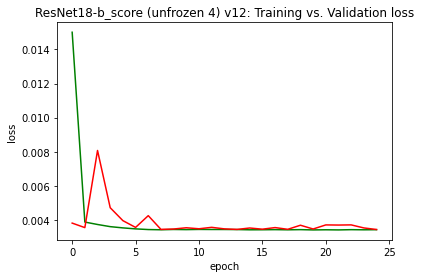

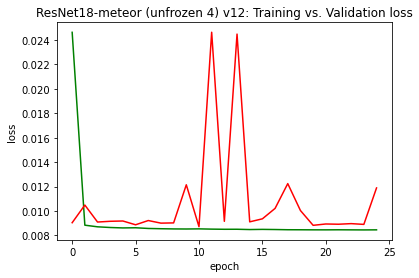

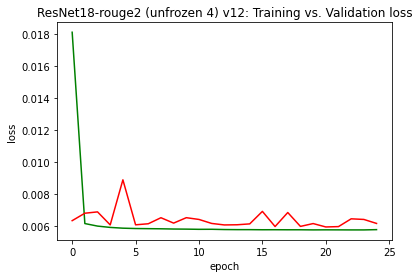

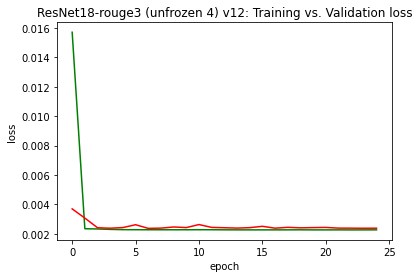

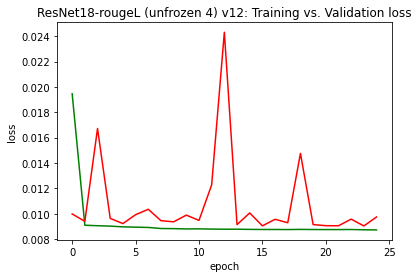

VERSION v38-1


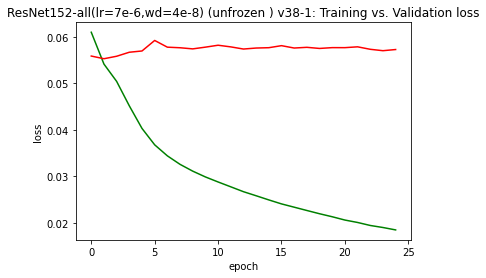

VERSION alexnet-v1


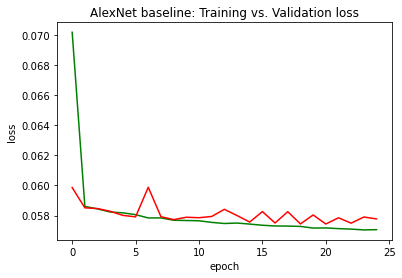

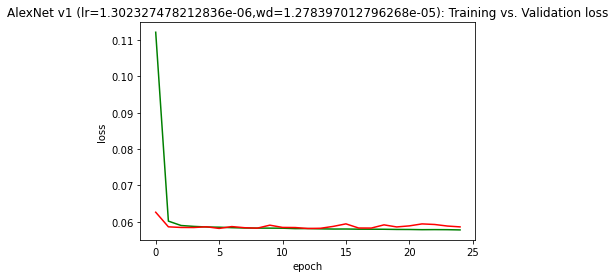

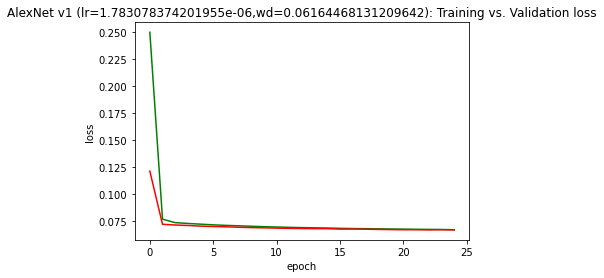

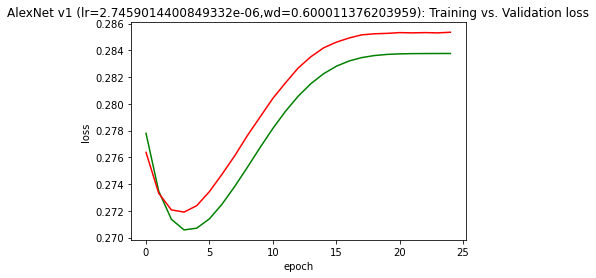

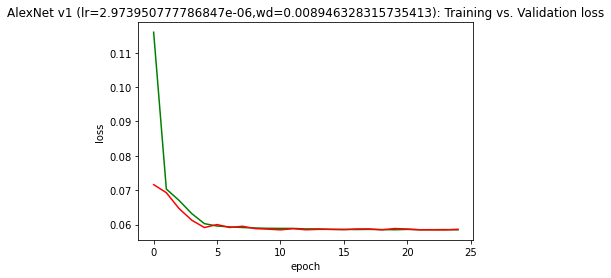

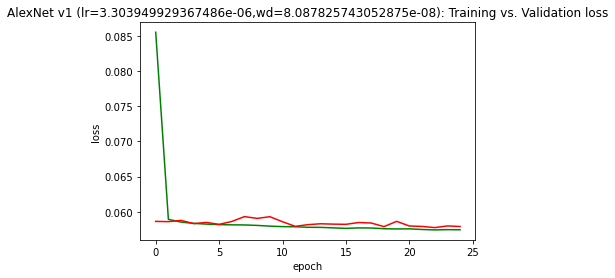

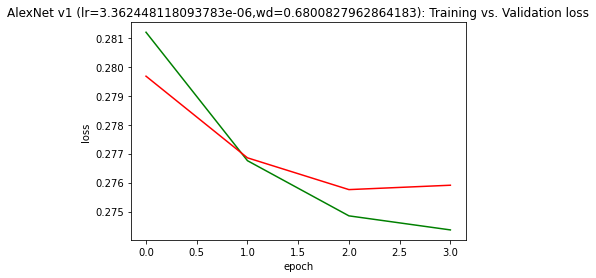

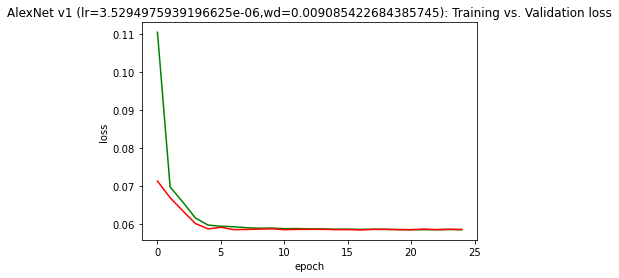

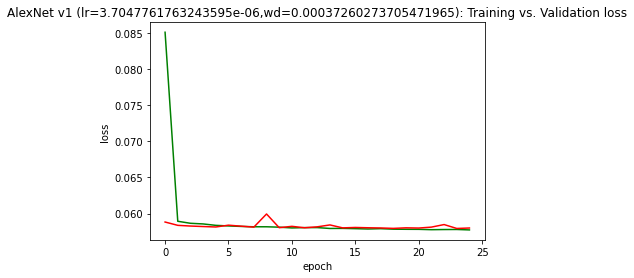

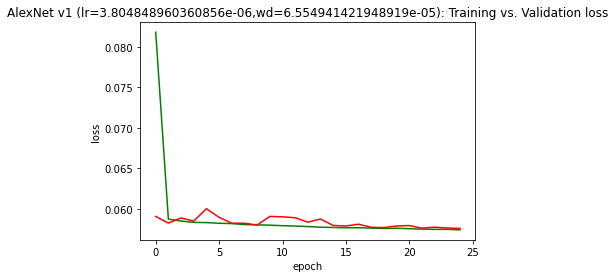

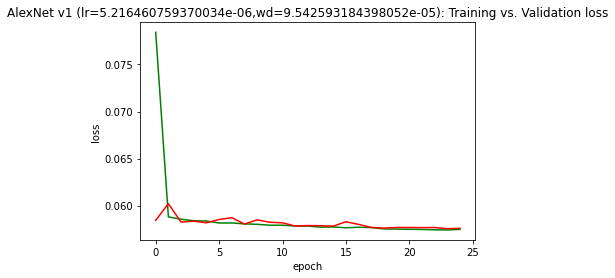

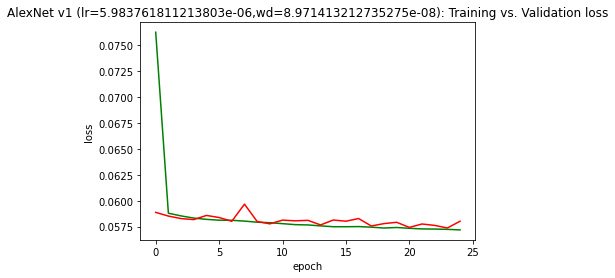

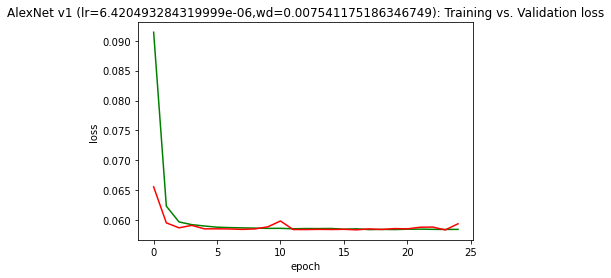

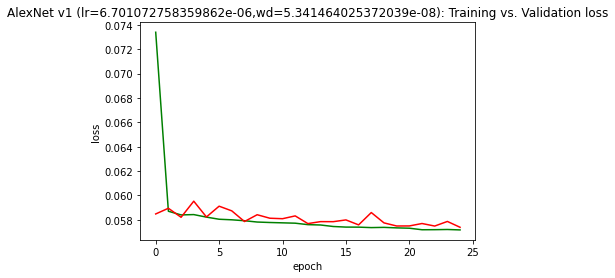

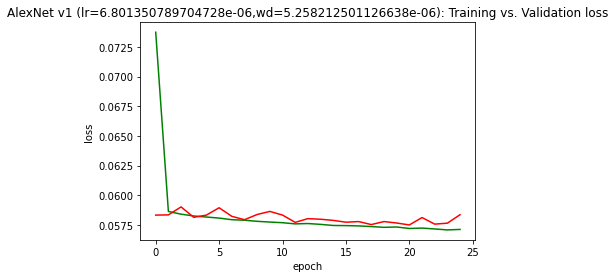

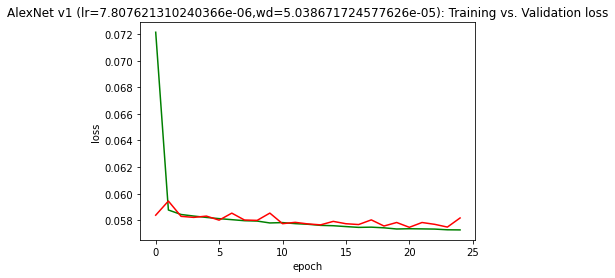

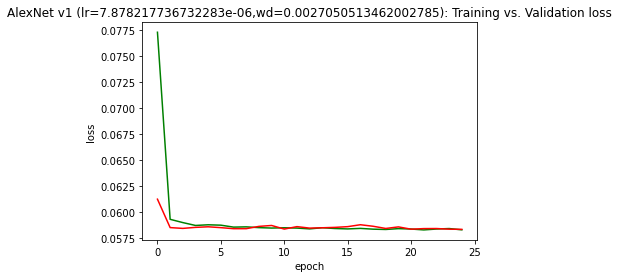

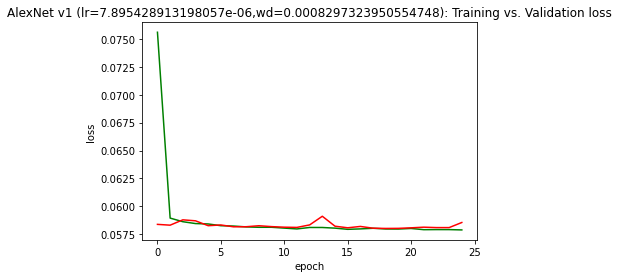

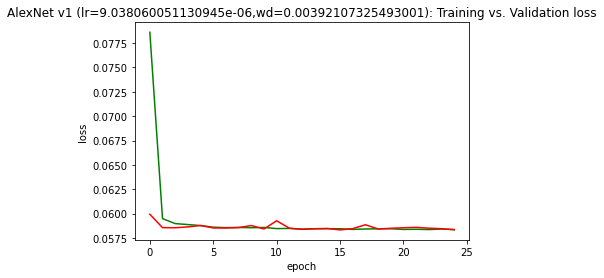

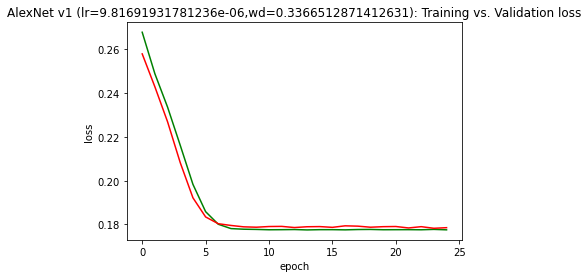

VERSION alexnet-v1(2)


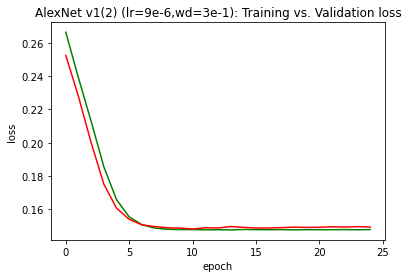

VERSION VGG-19-v1


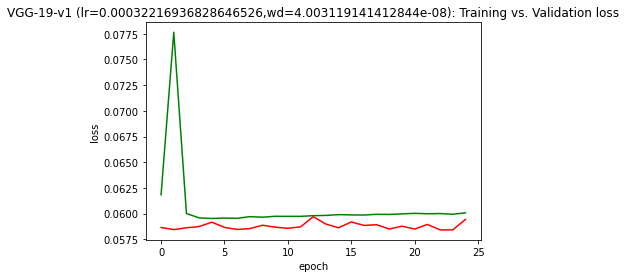

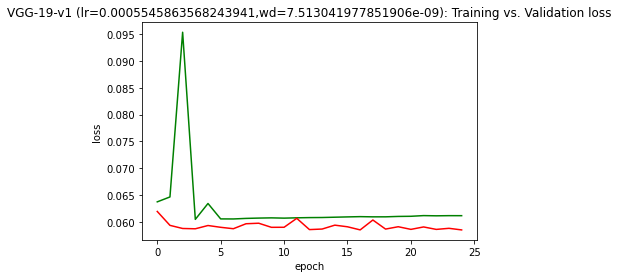

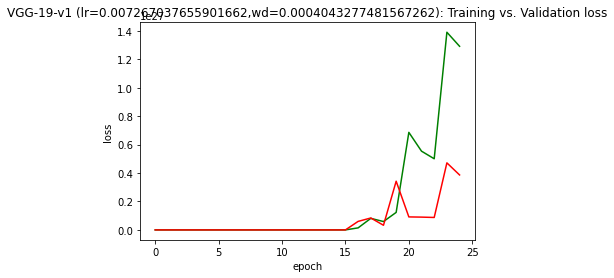

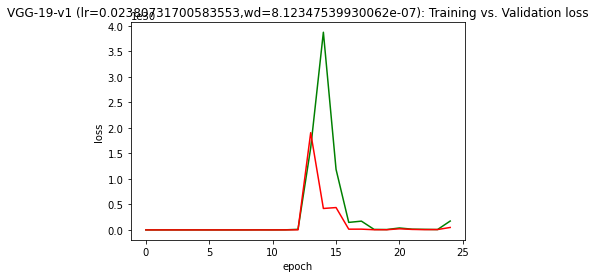

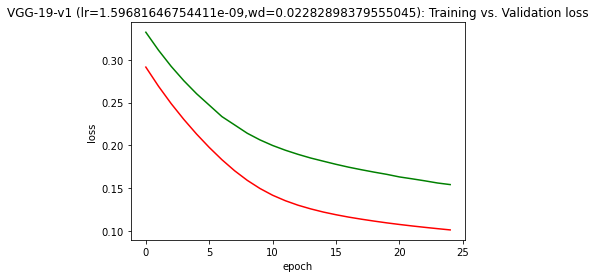

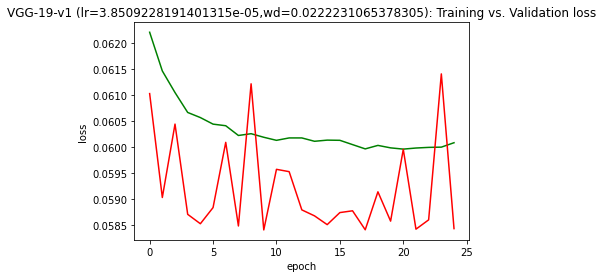

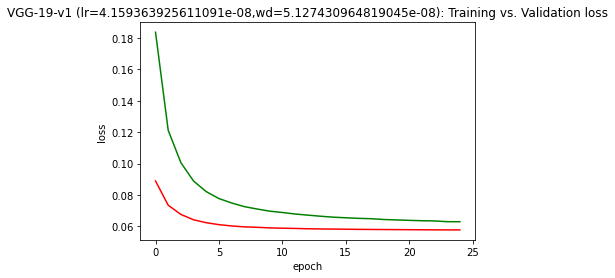

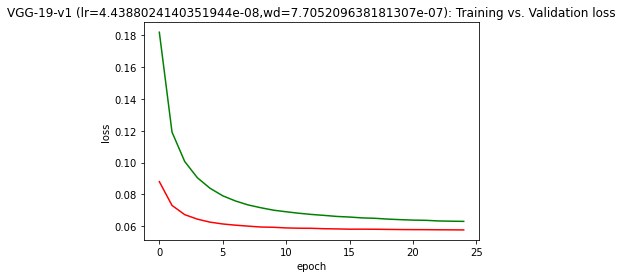

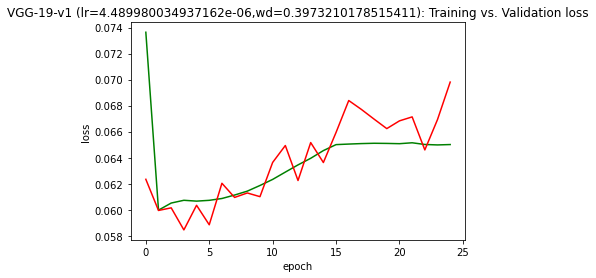

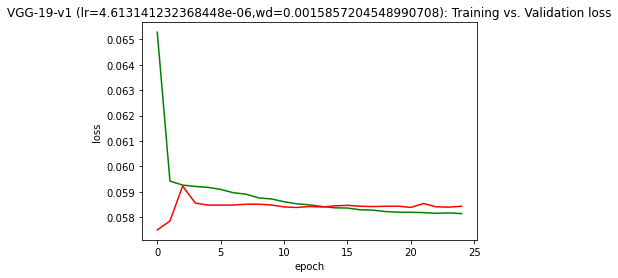

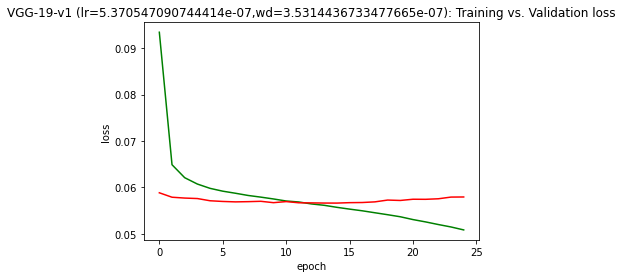

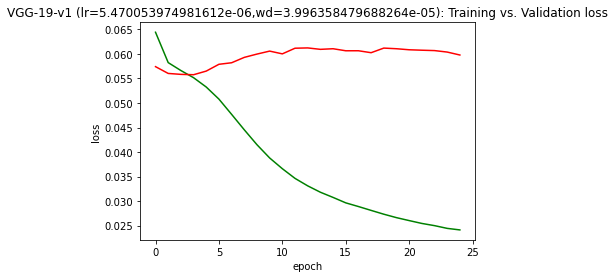

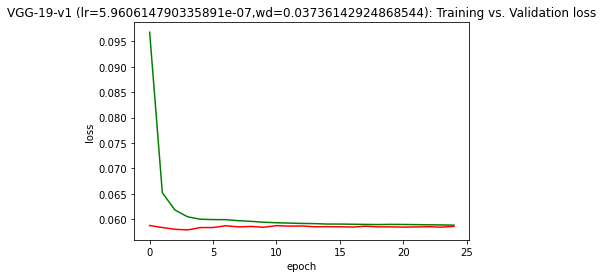

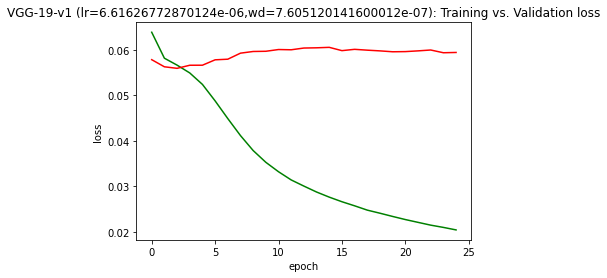

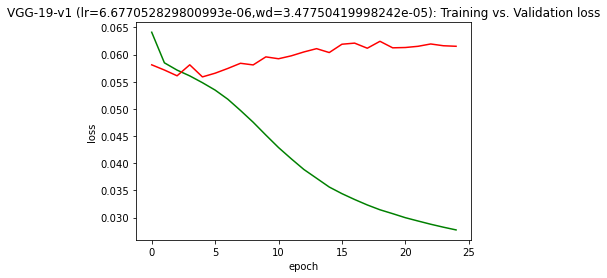

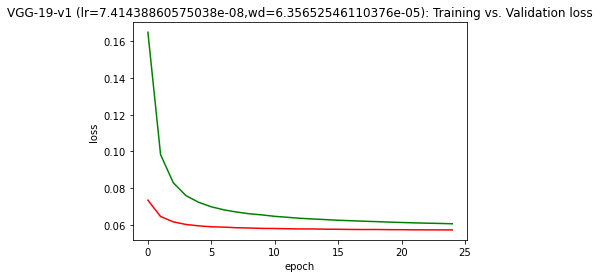

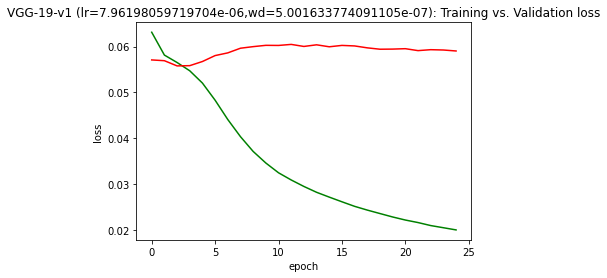

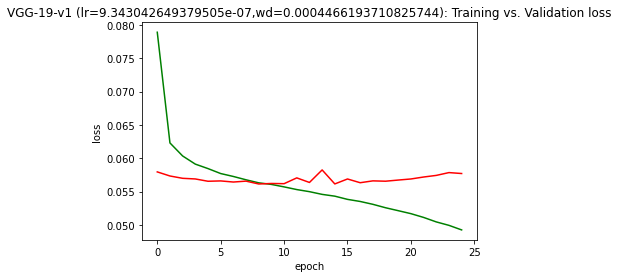

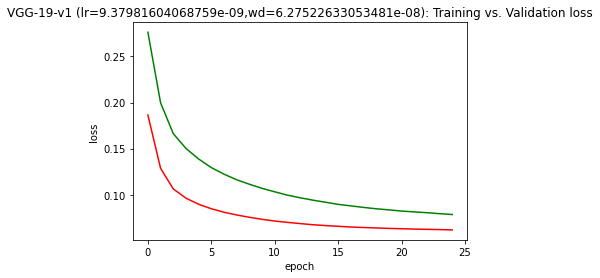

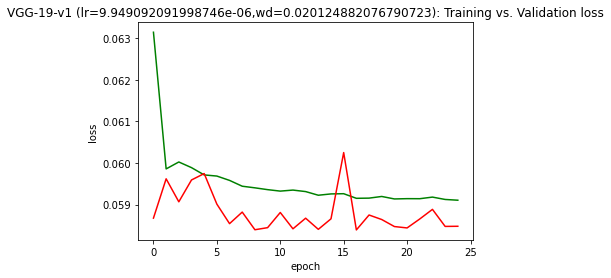

VERSION v39-resnet


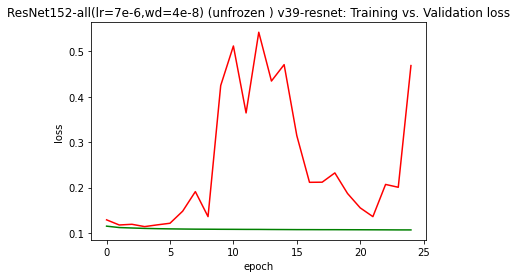

VERSION v39-resnet_pt


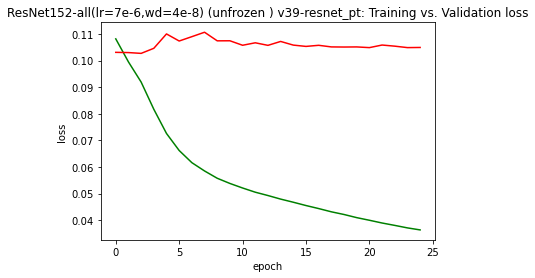

VERSION v39-resnet(bert)_pt


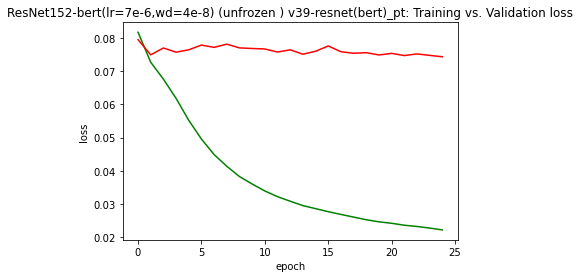

VERSION v39-resnet(cider)_pt


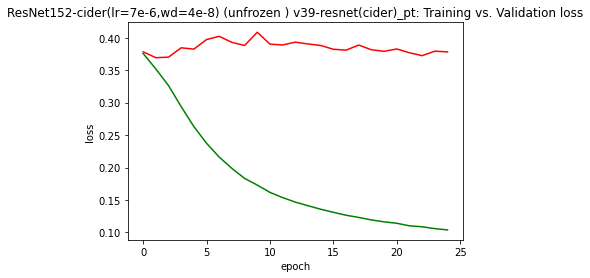

VERSION v40-resnet(bert)_pt


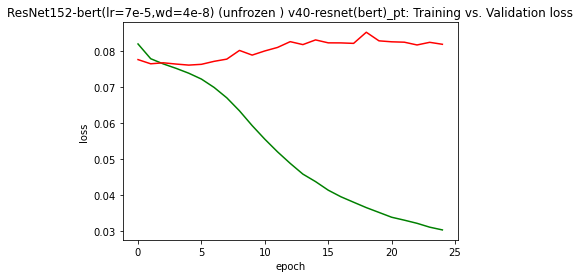

VERSION v41-resnet(bert)_pt


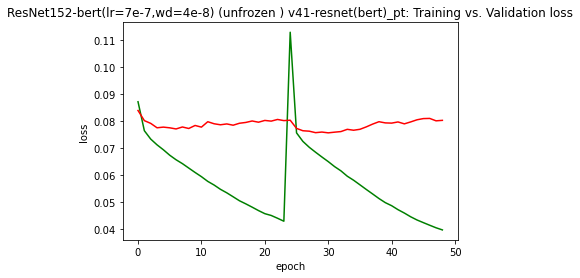

VERSION v42-resnet(bert)_pt


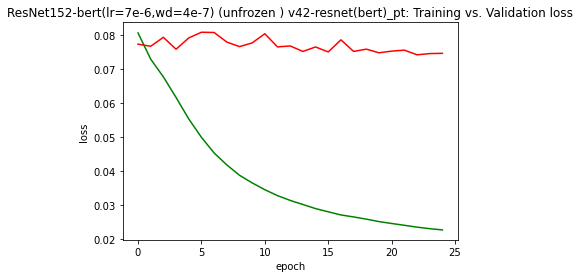

VERSION v43-resnet(bert)_pt


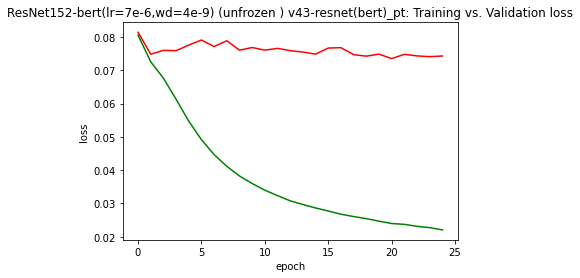

VERSION v44-resnet(bert)_pt


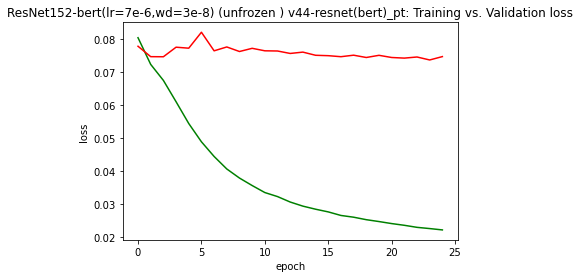

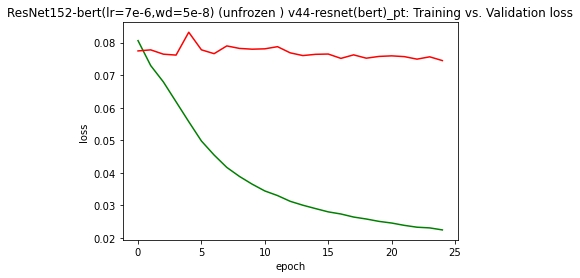

VERSION v45-resnet(bert)_pt


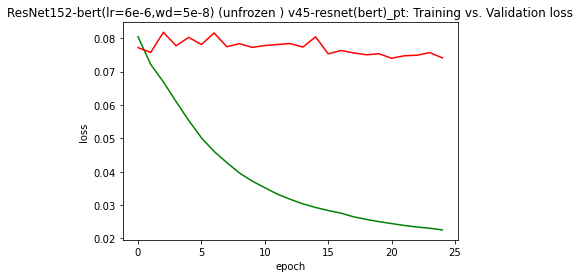

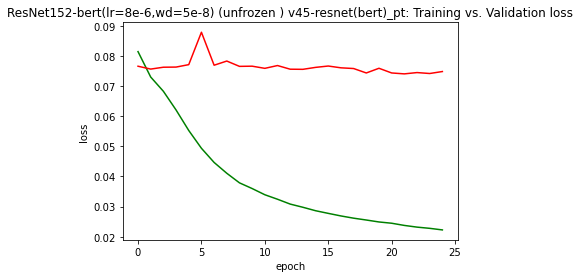

VERSION v40-resnet_pt


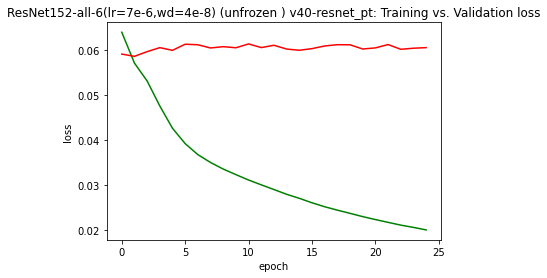

VERSION pascal50_v1_pt


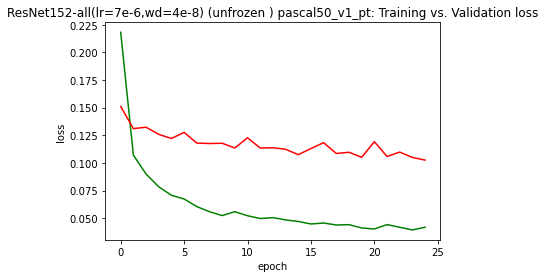

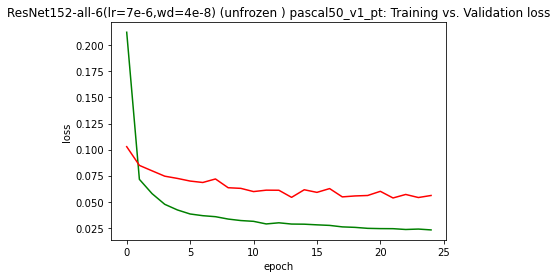

VERSION abstract50_v1_pt


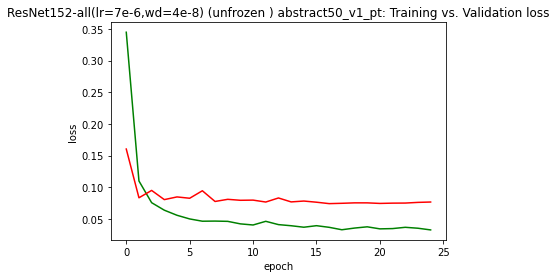

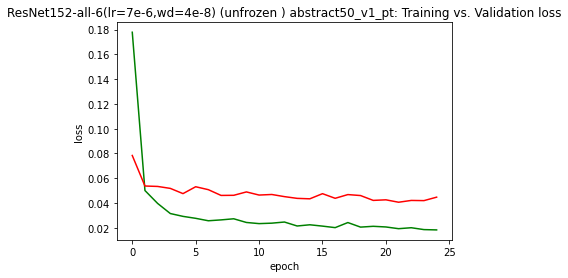

VERSION v46-resnet(cider)_pt


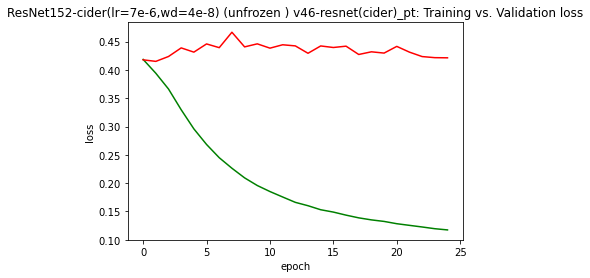

VERSION v46-resnet_pt


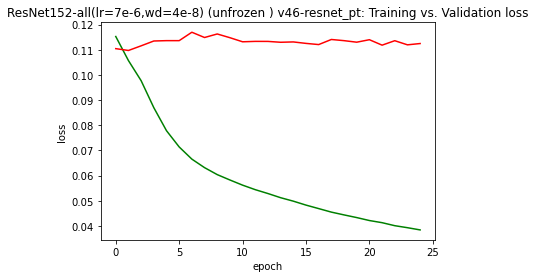

In [1463]:
versions = [
#     'v11', # RESNET 18
    'v12',
    #'v23-1','v23-2', 'v23-3', 'v23-4',  # unfrozen 4; target: RougeL; MSE
    #'v24-1','v24-2', 'v24-3', 'v24-4', # unfrozen 3,4; target: RougeL; MSE
    #'v25-1', 'v25-2', 'v25-3', 'v25-4', # unfrozen 4/3,4; target: RougeL; MSE (narrowing down LR)
#     'v26-1', 'v26-2', 'v26-3', 'v26-4', # unfrozen 4/3,4/2,3,4/all; target: RougeL; L1Loss (random search for LR and WD)
    # 'v27-1', 'v27-2', 'v27-3', 'v27-4', # unfrozen 4/3,4/2,3,4/all; target: all; L1Loss (random search for LR and WD)
    # 'v28-1', 'v28-2', 'v28-3', 'v28-4' # unfrozen 4/3,4/2,3,4/all; target: all; L1Loss (narrowing down LR and WD )
#     'v29-1', 'v29-2', 'v29-3', 'v29-4' # unfrozen 4/3,4/2,3,4/all; target: all; L1Loss (WD)
#      'v30-1', 'v30-2', 'v30-3', 'v30-4', 'v30-1(2)', 'v30-2(2)' # unfrozen 4/3,4/2,3,4/all; target: all; L1Loss (ResNet34)
#         'v31-1', 'v31-2', 'v31-3', 'v31-4', 'v31-2(2)', 'v31-3(2)', 'v31-4(2)', # unfrozen 4/3,4/2,3,4/all; target: all; L1Loss (ResNet50)
#     'v32(b_score,rouge2)', 'v32(rouge3)', 'v32(rougeL)', 'v32(meteor)' # # unfrozen 4/3,4/2,3,4/all; target: separate; L1Loss (ResNet50)
#     'v33-1', 'v33-2', 'v33-3', 'v33-4', 'v33-5', 'v33-6','v33-7'    # unfrozen all; target: all; L1Loss (ResNet101)
#     'v34-1', 'v34-2', 'v34-3', 'v34-4'                 # unfrozen all; target: all; L1Loss (ResNet101); tuning WD
#     'v35-1', 'v35-2', 'v35-3', 'v35-4', 'v35-5', 'v35-6', 'v35-7', 'v35-8' # unfrozen all; target: all; L1Loss (ResNet101); tuning LR base
#      'v36-1', 'v36-2', 'v36-3' # unfrozen 4/3,4/2,3,4; target: all; L1Loss (ResNet101); checking best v35 config with different frozen layers
#     'v37-1', 'v37-2', 'v37-3', 'v37-4',  # unfrozen all; target: separate; L1Loss (ResNet101)
    'v38-1', # 'v38-2', 'v38-3',
    
    
    "alexnet-v1", "alexnet-v1(2)",
    "VGG-19-v1",
    
      'v39-resnet', 'v39-resnet_pt',
    'v39-resnet(bert)_pt','v39-resnet(cider)_pt',
    
    "v40-resnet(bert)_pt", "v41-resnet(bert)_pt",   ## fine-tuning individual bert 
    "v42-resnet(bert)_pt", "v43-resnet(bert)_pt",
    "v44-resnet(bert)_pt",
    "v45-resnet(bert)_pt",
    
    'v40-resnet_pt',
    
    'pascal50_v1_pt',
    'abstract50_v1_pt',
    
    
    'v46-resnet(cider)_pt',    # individual cider1v1
    'v46-resnet_pt'               # all with cider1v1
]
log_folder = '/mnt/zeta_share_1/mkorchev/image_captioning/models/{}/logs/'
logfiles = []
for v in versions:
    print('VERSION {}'.format(v))
    folder = log_folder.format(v)
    logs = sorted(os.listdir(folder))
    for log in logs: 
        
        log_id =  log.replace('-LOG.log', '')
        training_loss = []
        validation_loss = []
        logfile = open(os.path.join(folder, log), 'r')
        line = '****'
        while line:
            line = logfile.readline()
            if line != '':
                s = line.strip('\n').split(',')
                train = s[0]
                val = s[1]
                training_loss.append(float(train))
                validation_loss.append(float(val))
        logfile.close()
        plt.plot(range(len(training_loss)), np.array(training_loss), c='green')
        plt.plot(range(len(validation_loss)), np.array(validation_loss), c='red')
        plt.title('{}: Training vs. Validation loss'.format(log_id))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

VERSION  v11
FILE: test_results_v11(b_score)_unfrozen 4.json


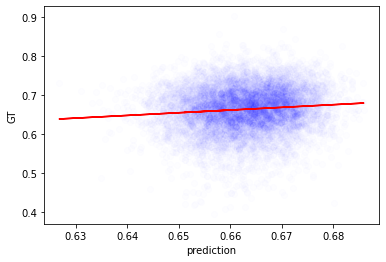

0.09732269708138644
FILE: test_results_v11(meteor)_unfrozen 4.json


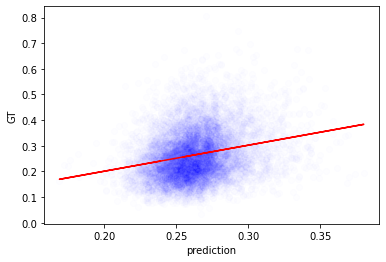

0.2445668843433834
FILE: test_results_v11(rouge2)_unfrozen 4.json


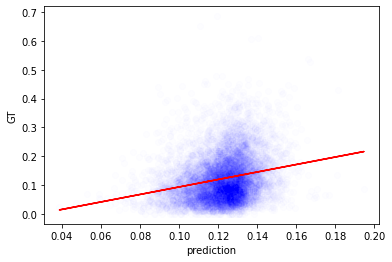

0.2316219531827114
FILE: test_results_v11(rouge3)_unfrozen 4.json


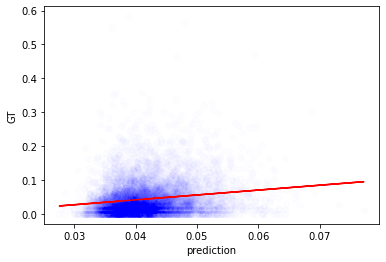

0.1628091932993837
FILE: test_results_v11(rougeL)_unfrozen 4.json


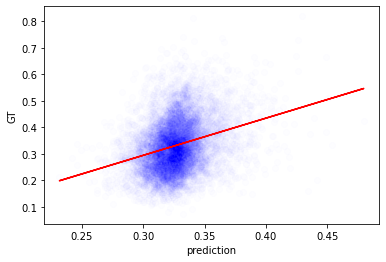

0.2954822219541636


<Figure size 432x288 with 0 Axes>

In [127]:
version = 'v9'
results_path = '/mnt/zeta_share_1/mkorchev/image_captioning/models/{}/results/'
plots_folder = '/mnt/zeta_share_1/mkorchev/image_captioning/models/{}/plots/'
metrics_v3 = [
    {
        'metric_id': 'BLEU',
        'callback': bleu_score
    }, 
    {
        'metric_id': 'Rouge2',
        'callback': rouge_scorer.RougeScorer(['rouge2'], use_stemmer=False).score,
        'output_transform': (lambda x: x['rouge2'][2])
    },
    {
        'metric_id': 'Rouge3',
        'callback': rouge_scorer.RougeScorer(['rouge3'], use_stemmer=False).score,
        'output_transform': (lambda x: x['rouge3'][2])
    },
    {
        'metric_id': 'RougeL',
        'callback': rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False).score,
        'output_transform': (lambda x: x['rougeL'][2])
    },
    {
        'metric_id': 'Meteor',
        'callback': meteor_score
    }, 
    {
        'metric_id': 'BERTScore',
        'callback': bert_score_callback
    },
    {
        'metric_id': 'CIDEr',
        'callback': cider_score_callback,
        'consensus_needed': True
    }
]

for v in [
    
    'v11'
#     'v22-1','v22-2', 'v22-3', 'v22-4',            # RANDOM SEARCH FOR HP, all metrics
#     'v23-1','v23-2', 'v23-3', 'v23-4',            # RANDOM SEARCH FOR ROUGEL
#     'v24-1','v24-2', 'v24-3', 'v24-4',            # RANDOM SEARCH FOR ROUGEL
#     'v25-1', 'v25-2', 'v25-3', 'v25-4',           # FINE-TUNING FOR ROUGEL
#      'v26-1', 'v26-2', 'v26-3', 'v26-4'           # RANDOM SEARCH FOR ROUGEL
#     'v27-1', 'v27-2', 'v27-3', 'v27-4',           # RANDOM SEARCH FOR HP, all metrics
#     'v28-1', 'v28-2', 'v28-3', 'v28-4',           # RANDOM SEARCH FOR HP, all metrics
#      'v29-1', 'v29-2', 'v29-3', 'v29-4',          # FINE-TUNING FOR all
#      'v30-1', 'v30-2', 'v30-3', 'v30-4', 'v30-1(2)', 'v30-2(2)',           # ResNet 34, fine-tuning for all
#     'v31-1', 'v31-2', 'v31-3', 'v31-4', 'v31-2(2)', 'v31-3(2)', 'v31-4(2)',  # ResNet 50, fine-tuning for all
#     'v32(b_score,rouge2)', 'v32(rouge3)', 'v32(rougeL)', 'v32(meteor)'    # ResNet 50, fine-tuning for individual
#     'v33-1', 'v33-2', 'v33-3', 'v33-4', 'v33-5',       # ResNet 101, fine-tuning for all
#     'v33-6',            ######
#     'v33-7',
#     'v34-1', 'v34-2', 'v34-3', 'v34-4'
#      'v35-1', 'v35-2', 'v35-3', 'v35-4', 
#     'v35-5', 
#     'v35-6',                                  # 2nd best  
#     'v35-7', 'v35-8',
#     'v36-1', 'v36-2', 'v36-3'
#     'v37-1', 'v37-2', 'v37-3', 'v37-4',       # single metric 
#     'v38-1',                                  # BEST for 5 metrics
#     'v38-2', 'v38-3',
#     'alexnet-v1',
#     "alexnet-v1(2)",
#     "VGG-19-v1",
    
#     'v39-resnet', 
#     'v39-resnet_pt',                               ## best 7 metric config 
#     'v39-resnet(bert)_pt','v39-resnet(cider)_pt',   ## best individual bert config
    
    
#     "v40-resnet(bert)_pt", "v41-resnet(bert)_pt",
#     "v42-resnet(bert)_pt", "v43-resnet(bert)_pt",
#     "v44-resnet(bert)_pt",
#     "v45-resnet(bert)_pt",
#     'v40-resnet_pt',                               ## ALL EXCEPT CIDER, so comment out from metrics
#     'pascal50_v1_pt',
#     'abstract50_v1_pt',
    
    
#     'v46-resnet(cider)_pt',    # individual cider1v1
#     'v46-resnet_pt',               # all with cider1v1
#     'v47-resnet_consensus_pt',
    
#     'baseline152',
#     'baseline152_pt'
    
#     'baseline152-0',
#     'baseline152-1',
#     'baseline152-2',
#     'baseline152-3',
#     'baseline152-4',
#     'baseline152-5',
#     'baseline152-6',
    
#     'baseline152_pt-0',
#     'baseline152_pt-1',
#     'baseline152_pt-2',
#     'baseline152_pt-3',
#     'baseline152_pt-4',
#     'baseline152_pt-5',
#     'baseline152_pt-6'
    
    
    ]:
    print('VERSION ', v)
    filenames = sorted(os.listdir(results_path.format(v)))
    for f in filenames:
        with open(os.path.join(results_path.format(v), f), 'r') as r:
            result = json.load(r)
#             result = result['ResNet101-single output (unfrozen 4) v2']
            print('FILE: {}'.format(f))
            if 'gt' in result:
#                 mtx_gt = np.array(result['gt'], dtype='float') 
#                 mtx_pred = np.array(result['pred'], dtype='float')
#                 print(mtx_gt[0])
#                 print(mtx_pred.shape)
#                 pearson_overall = scipy.stats.pearsonr(mtx_gt, mtx_pred)
#                 print('Overall :: {}'.format(pearson_overall))
                if isinstance(result['pearson_score'], list) and len(result['pearson_score']) != 1 :
                    for score_ind in range(len(result['pearson_score'])):
                        actuals = np.array(result['gt']).astype(float)
                        predictions = np.array(result['pred']).astype(float)
                        if predictions.shape[1] == actuals.shape[1]:
                            pearson_score = scipy.stats.pearsonr(actuals[:,score_ind], predictions[:,score_ind])[0]
#                             plt.scatter(predictions[:, score_ind], actuals[:, score_ind], c='blue', alpha=0.008)
#                             m, b = np.polyfit(predictions[:, score_ind], actuals[:, score_ind], 1)
#                             plt.plot(predictions[:, score_ind], m*predictions[:, score_ind] + b, c='red')
#                             plt.title('{}'.format(metrics_v3[score_ind]['metric_id']))
#                             plt.xlabel('predction')
#                             plt.ylabel('GT')
#                             plt.ylim(0.0, 1.0)
#                             plt.xlim(0.0, 1.0)
#                             plt.show()
#                             plt.clf()
                        spearman = scipy.stats.spearmanr(actuals[:,score_ind], predictions[:,score_ind])[0]
                        print('{} ::: pearson score: {:.4f}'.format(metrics_v3[score_ind]['metric_id'], float(result['pearson_score'][score_ind])))
#                         print('{} ::: spearman score: {}'.format(metrics[score_ind]['metric_id'], spearman))

                else:
                    actuals = np.array(result['gt']).astype(float)
                    predictions = np.array(result['pred']).astype(float)
                    if predictions.shape[1] == actuals.shape[1]:
                        pearson_score = scipy.stats.pearsonr(actuals[:,0], predictions[:,0])[0]
                        plt.scatter(predictions[:, 0], actuals[:, 0], c='blue', alpha=0.008)
                        m, b = np.polyfit(predictions[:, 0], actuals[:, 0], 1)
                        plt.plot(predictions[:, 0], m*predictions[:, 0] + b, c='red')
#                         plt.title('{}'.format(metrics_v3[0]['metric_id']))
                        plt.xlabel('prediction')
                        plt.ylabel('GT')
#                         plt.ylim(0.0, 1.0)
#                         plt.xlim(0.0, 1.0)
                        plt.show()
                        plt.clf()
                    print(result['pearson_score'])
#                     print('pearson score: {:.4f}'.format(float(result['pearson_score'])))
            else: 
                # calculate pearson score for old implementations 
                for key in result:
                    for ind in range(len(metrics)):
                        actuals = np.array(result[key]['gt']).astype(float)
                        predictions = np.array(result[key]['pred']).astype(float)
                        
                        if predictions.shape[1] == actuals.shape[1]:
                            pearson_score = scipy.stats.pearsonr(actuals[:,ind], predictions[:,ind])[0]
#                             pearson_score = scipy.stats.pearsonr(actuals, predictions)[0]
#                             plt.scatter(predictions[:, ind], actuals[:, ind], c='blue', alpha=0.008)
#                             plt.scatter(predictions, actuals, c='blue', alpha=0.008)
#                             plt.title('{}'.format(metrics_v3[ind]['metric_id']))
#                             plt.xlabel('pred')
#                             plt.ylabel('GT')
#                             plt.savefig(os.path.join(plots_folder.format(v), '{}::{} RAW.png'.format(key, metrics_v3[ind]['metric_id'])))
#                             plt.show()
#                             plt.clf()
#                             plt.scatter(predictions[:, ind], actuals[:, ind], c='blue', alpha=0.008)
#                             plt.title('{}'.format(metrics_v3[ind]['metric_id']))
#                             plt.xlabel('pred')
#                             plt.ylabel('GT')
#                             plt.ylim(0.0, 1.0)
#                             plt.xlim(0.0, 1.0)
#                             plt.Normalize(vmin=0.0, vmax=1.0)
#                             plt.savefig(os.path.join(plots_folder.format(v), '{}::{} NORM.png'.format(key, metrics_v3[ind]['metric_id'])))
#                             plt.show()
                        else: 
                            pearson_score = scipy.stats.pearsonr(actuals[:,ind], predictions[:,0])[0]
                        print('{}::{}, pearson score: {}\n'.format(key, metrics_v3[ind]['metric_id'], pearson_score))

In [ ]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v3/annotations_map_v3.json', 'r') as f:
    ann_map = json.load(f)
ann_map

In [ ]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_train2014_embed/id_name0.json', 'r') as f:
    tmp = json.load(f)
tmp

In [ ]:
np.load('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_train2014_embed/embedding0.npy')[0]

In [ ]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco/annotations/captions_train2014.json', 'r') as f:
    tmp = json.load(f)
    

In [ ]:
tmp['images']

In [ ]:
tmp = scipy.io.loadmat('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/tmp/Datasets/abstract50S.mat')

In [ ]:
tmp = tmp['abs_sent'][0] # get actual list of images 


In [ ]:
tmp[1][1][0]

In [ ]:
import urllib.request 


In [ ]:
for i, _ in enumerate(tmp):
    urllib.request.urlretrieve(tmp[i][0][0], '/mnt/zeta_share_1/mkorchev/image_captioning/datasets/pascal50/' + tmp[i][0][0].rsplit('/', 1)[-1])
#     print(tmp[i][1][0].rsplit('/', 1)[-1])

In [ ]:
annotationsMeta['images']

In [ ]:
annotationsMeta['annotations']

In [ ]:
abstract_annotations_list = []
abstract_images_list = []
for i, _ in enumerate(tmp):
    img = tmp[i]
    filename = (img[1][0]).rsplit('/', 1)[-1]
    img_id = str(i)
    abstract_images_list.append({'id': img_id, 'file_name': filename})
    
    cap_id = 0
    for cap in img[0][0]:
        abstract_annotations_list.append({
            'image_id': img_id,
            'id': cap_id,
            'caption': str(cap[0])
        })
        cap_id += 1

In [ ]:
abstract_annotations_list

In [ ]:
abstract_images_list

In [ ]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/abstract50/annotations/abstract_annotations.json', 'w') as f:
    json.dump({
        'images': abstract_images_list,
        'annotations': abstract_annotations_list
    }, f)

In [ ]:
with open('./codebase/coco_caption/data/abstract50_corpus.json', 'w') as f:
    json.dump([ {'image_id': c['image_id'], 'caption': c['caption']} for c in pascal_annotations_list], f)

In [ ]:
with open('./codebase/coco_caption/data/coco_train2014_corpus_eval_ref.json', 'r') as f:
    tmp = json.load(f)

In [ ]:
with open('./codebase/coco_caption/data/coco_train2014_corpus_eval_test.json', 'r') as f:
    tmp2 = json.load(f)

In [ ]:
with open('./codebase/coco_caption/data/gts.json', 'w') as f:
    json.dump(tmp[:4], f)
with open('./codebase/coco_caption/data/cands.json', 'w') as f:
    json.dump(tmp2[:1], f)

In [ ]:
tmp[:8]

In [ ]:
tempmap = defaultdict(list)
for c in tmp[:40028]:
    tempmap[c['image_id']].append(c['caption'])
len(tempmap.keys())

In [ ]:
with open('./codebase/coco_caption/results/tmp_stem.json', 'r') as f:
    tmp_res1 = json.load(f)
with open('./codebase/coco_caption/results/tmp2_stem.json', 'r') as f:
    tmp_res2 = json.load(f)

In [ ]:
for key in tmp_res1:
    if abs(tmp_res1[key] - tmp_res2[key]) != 0:
        print('DISCREPANCY: \n CUSTOM {} :: PTB {} '.format(tmp_res1[key], tmp_res2[key]))

In [ ]:
cider_raw_list = [cider_score_map[key] for key in cider_score_map]

In [ ]:
plt.title('cider')
plt.hist(cider_raw_list, bins=50)
plt.show()

In [999]:
with open('./codebase/coco_caption/data/coco2014val_refs.json', 'r') as f:
    tmp = json.load(f)

In [1000]:
consensus_map = {}
for c in tmp:
    if c['image_id'] in consensus_map:
        consensus_map[c['image_id']].append(c['caption'])
    else:
        consensus_map[c['image_id']] = [c['caption']]

In [ ]:
'\n'.join(consensus_map['318556-48'])

In [1001]:
with open('./codebase/coco_caption/data/ref_council_map_val.json', 'w') as f:
    json.dump(consensus_map, f)

In [ ]:
rouge_scorer.RougeScorer(['rougeLsum'], use_stemmer=False).score('\n'.join(consensus_map['318556-48']), 'cock and tits and all that stuff')

In [ ]:
with open('./codebase/coco_caption/results/cider_scores_map(df_control).json', 'r') as f:
    tmp = json.load(f)

In [ ]:
tmp

In [1051]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco/annotations/captions_val2014.json', 'r') as f:
    tmp = json.load(f)

In [ ]:
tmp['images']

In [1052]:
name_to_id_map = {}
for im in tmp['images']:
    name_to_id_map[im['file_name']] = im['id']
name_to_id_map        

{'COCO_val2014_000000391895.jpg': 391895,
 'COCO_val2014_000000522418.jpg': 522418,
 'COCO_val2014_000000184613.jpg': 184613,
 'COCO_val2014_000000318219.jpg': 318219,
 'COCO_val2014_000000554625.jpg': 554625,
 'COCO_val2014_000000397133.jpg': 397133,
 'COCO_val2014_000000574769.jpg': 574769,
 'COCO_val2014_000000060623.jpg': 60623,
 'COCO_val2014_000000309022.jpg': 309022,
 'COCO_val2014_000000005802.jpg': 5802,
 'COCO_val2014_000000222564.jpg': 222564,
 'COCO_val2014_000000118113.jpg': 118113,
 'COCO_val2014_000000193271.jpg': 193271,
 'COCO_val2014_000000224736.jpg': 224736,
 'COCO_val2014_000000483108.jpg': 483108,
 'COCO_val2014_000000403013.jpg': 403013,
 'COCO_val2014_000000374628.jpg': 374628,
 'COCO_val2014_000000328757.jpg': 328757,
 'COCO_val2014_000000384213.jpg': 384213,
 'COCO_val2014_000000293802.jpg': 293802,
 'COCO_val2014_000000086408.jpg': 86408,
 'COCO_val2014_000000037777.jpg': 37777,
 'COCO_val2014_000000372938.jpg': 372938,
 'COCO_val2014_000000386164.jpg': 38616

In [ ]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_train2014_embed/id_name0.json', 'r') as f:
    tmp = json.load(f)
tmp

In [1053]:
MODE = 'val'
total_embed_list = []
for i in range(10):
    with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_{}2014_embed/id_name{}.json'.format(MODE, i), 'r') as f:
        indexing_file = json.load(f)
    embed_file = np.load('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_{}2014_embed/embedding{}.npy'.format(MODE, i))
    for ind in indexing_file:
        total_embed_list.append((name_to_id_map['{}.jpg'.format(ind['name'])], embed_file[ind['id']]))
    
total_embed_list = np.array(total_embed_list)

In [ ]:
total_embed_list[0][1]

In [1054]:
np.save(open("/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_{}2014_embed/total_image_embedding_list.npy".format(MODE), "wb"), total_embed_list)

In [1055]:
em1 = np.load('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_{}2014_embed/total_image_embedding_list.npy'.format(MODE), allow_pickle=True)
em1[0]

array([139,
       array([ 0.67508507, -0.02576649, -0.00552772, ...,  0.4158064 ,
       -0.08558976,  0.5395547 ], dtype=float32)], dtype=object)

In [ ]:
em1[0][1].shape

In [ ]:
with open(path_to_annotations, 'r') as f:
    tmp2 = json.load(f)

In [ ]:
tmp2['images']

In [1056]:
cap_em = np.load('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_{}2014_captions_embed/coco2014val_caption_embeddings.npy'.format(MODE), allow_pickle=True)

In [1057]:
len(cap_em)

202654

In [1058]:
indexing_map = {}
for i in range(len(cap_em)):
    if cap_em[i][0] in indexing_map:
        indexing_map[cap_em[i][0]].append(i)
    else:
        indexing_map[cap_em[i][0]] = [i]
        

In [1059]:
json.dump(indexing_map, open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_{}2014_embed/embed_indexing_map.json'.format(MODE), 'w'))

In [1060]:
indexing_map[373346]

KeyError: 373346

In [ ]:
t = json.load(open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_train2014_embed/embed_indexing_map.json', 'r'))
t

VERSION v10


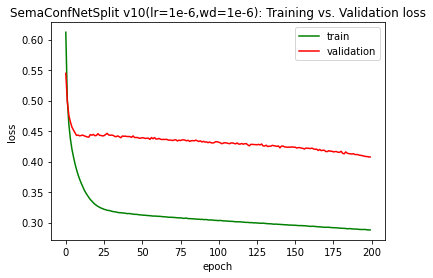

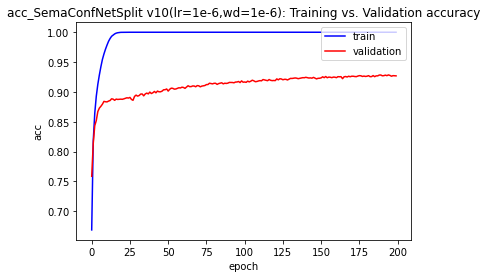

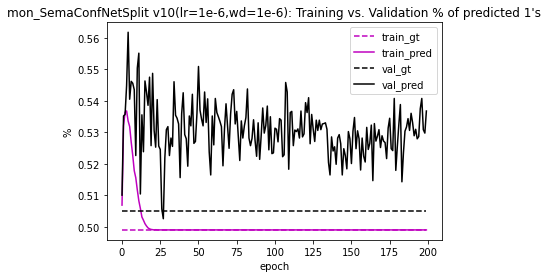

VERSION v10-DD_final


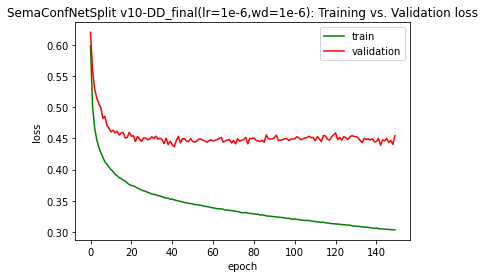

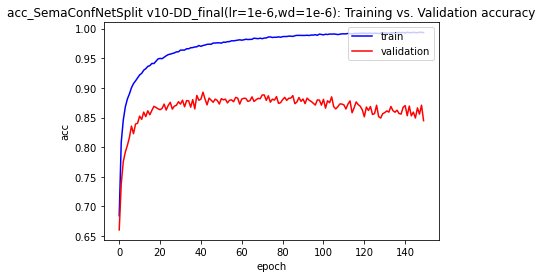

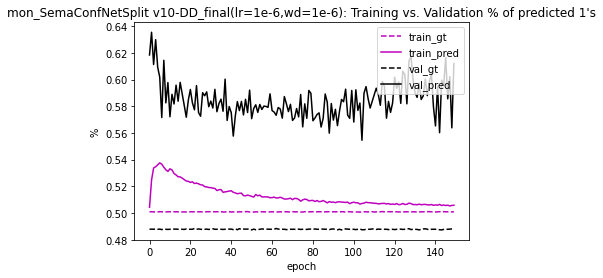

VERSION v10-resnet_embeds-DD_final


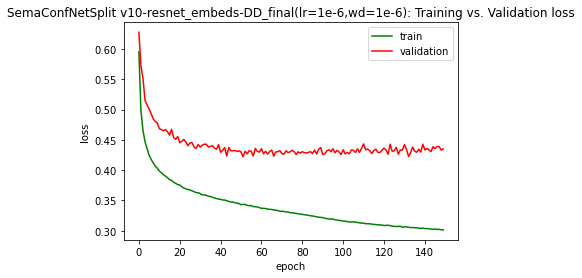

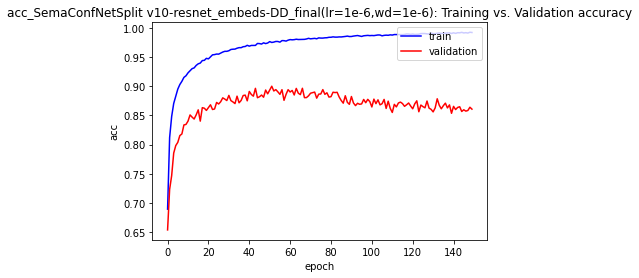

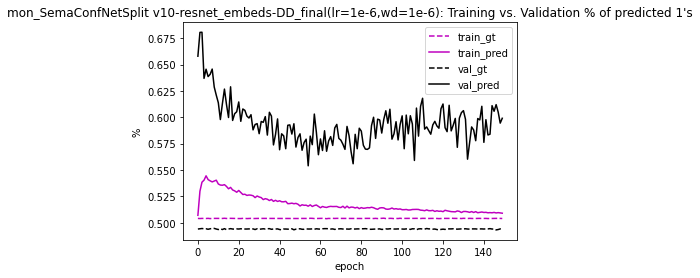

VERSION v10-resnet_embeds-MP2


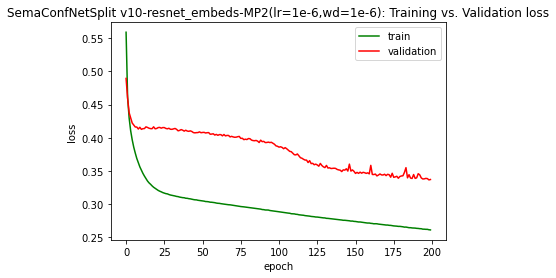

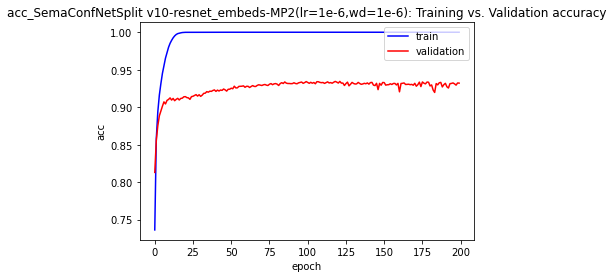

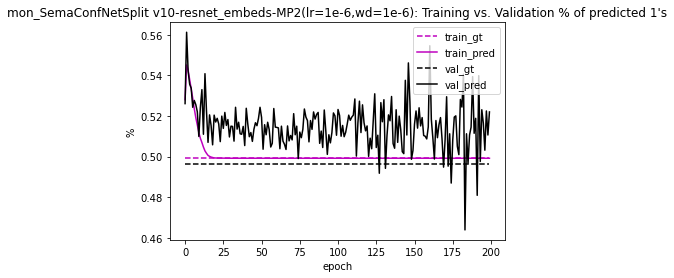

VERSION v10-resnet_embeds-MP3


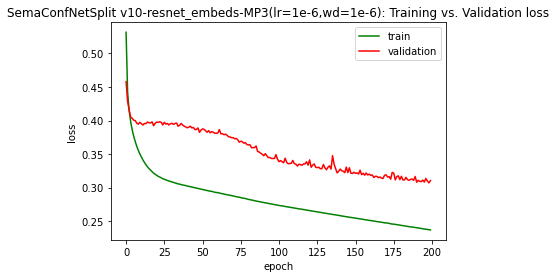

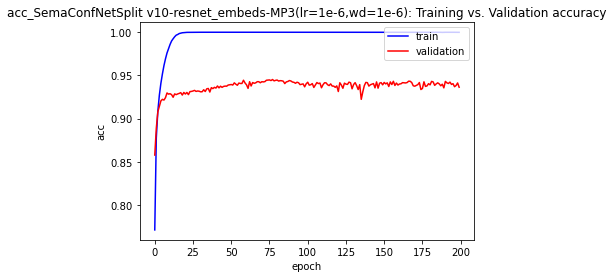

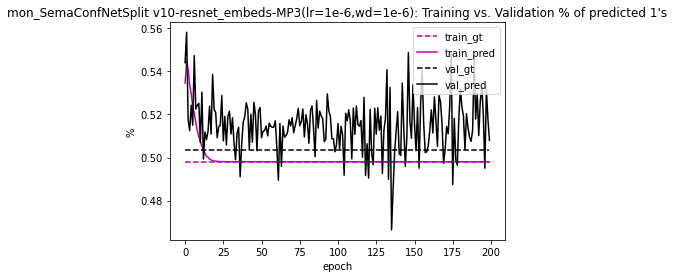

VERSION v10-resnet_embeds-MP3-2


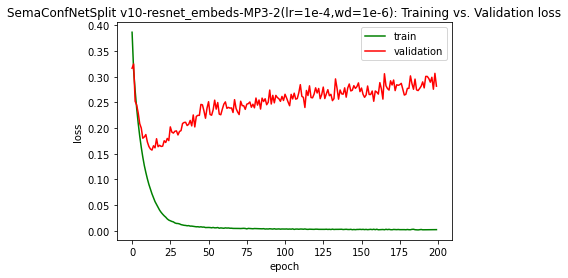

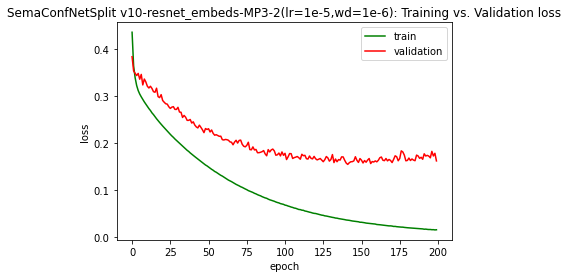

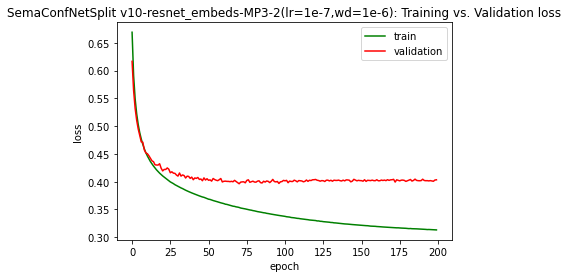

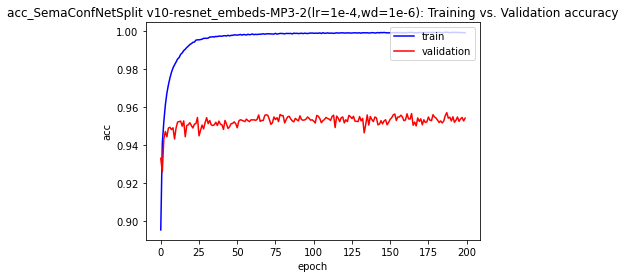

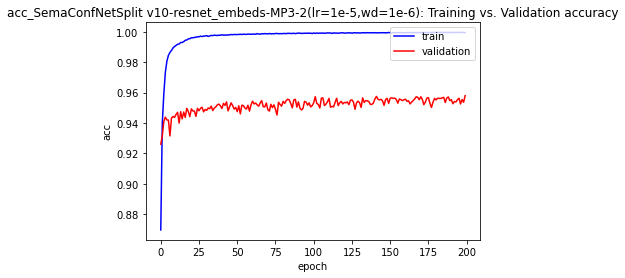

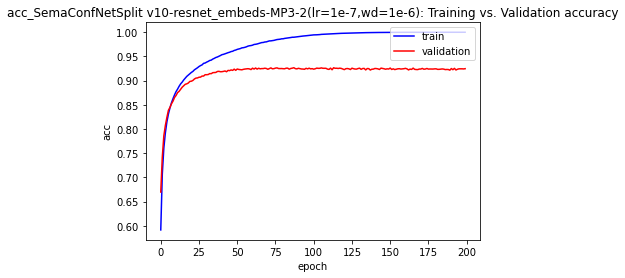

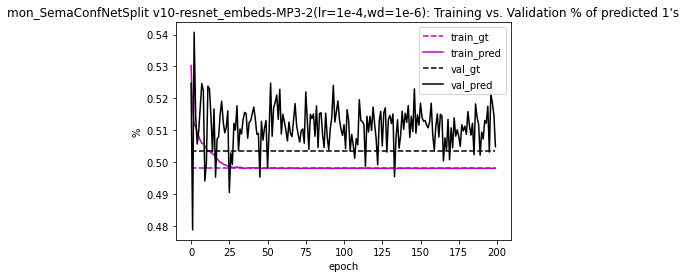

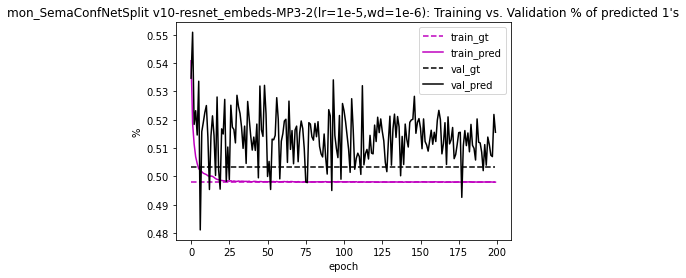

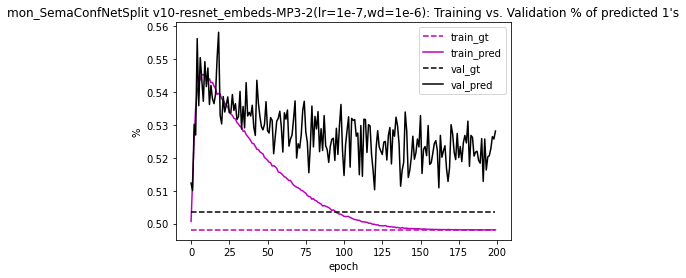

VERSION v10-resnet_embeds-MP3-3


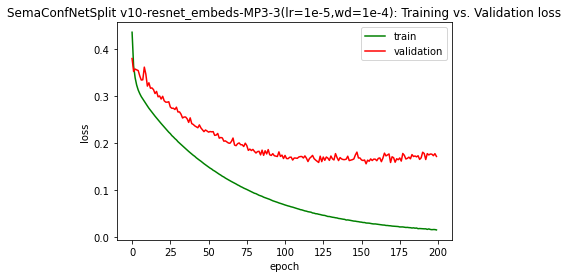

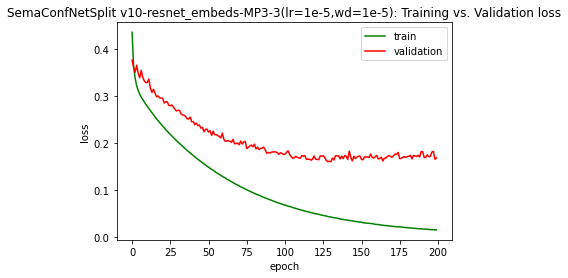

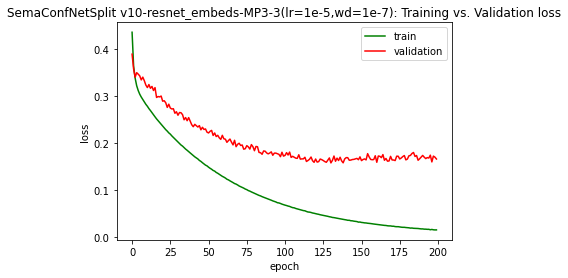

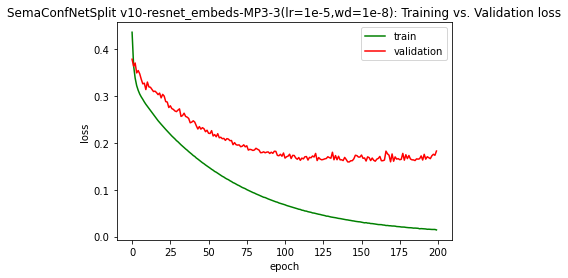

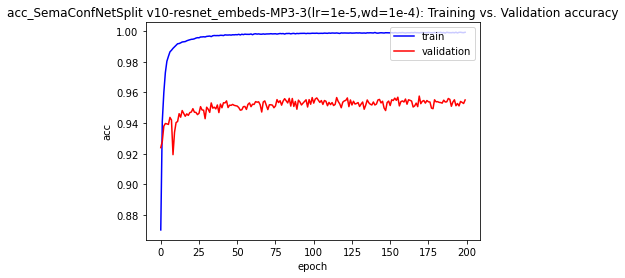

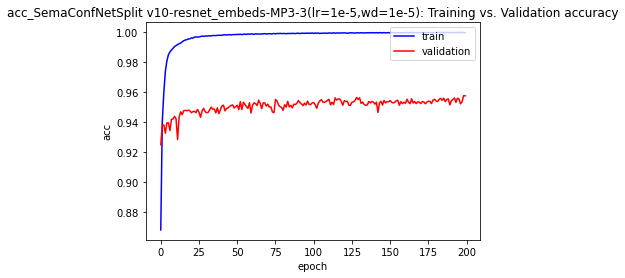

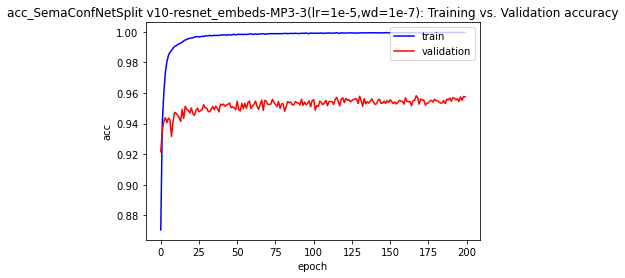

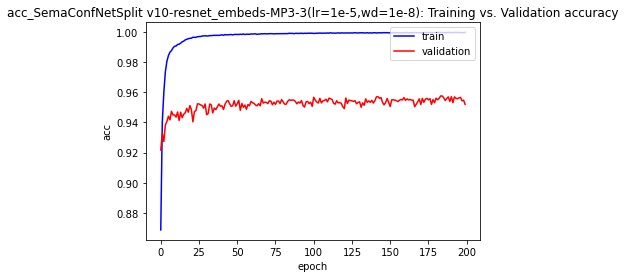

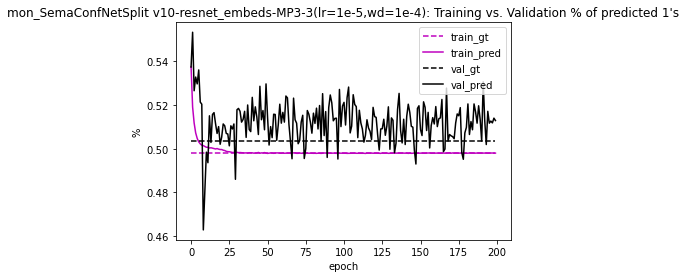

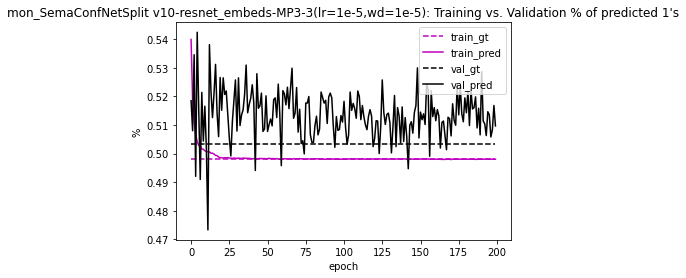

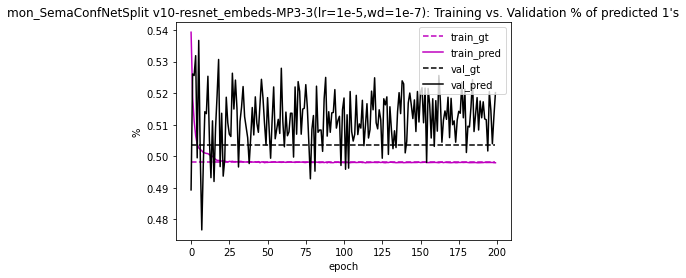

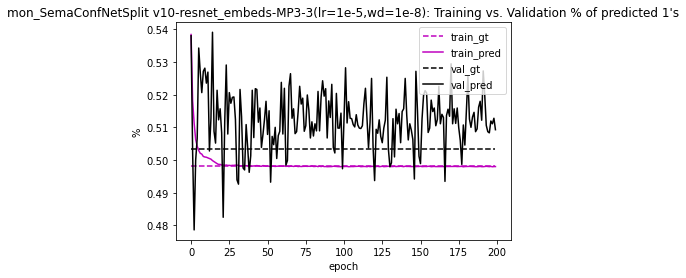

VERSION v10-resnet_embeds-MP3-4


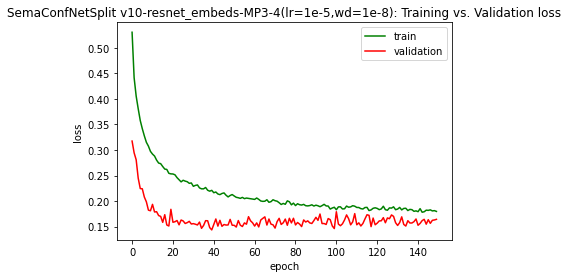

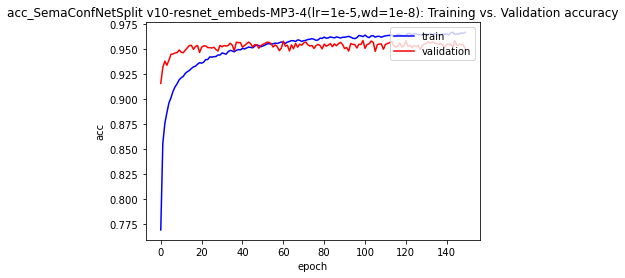

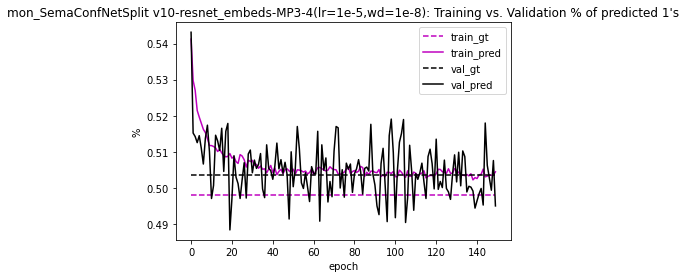

In [1031]:
# SemaConfNet
versions = [
#     'v2',
#     'v2-2',
#     'v2-3',
#     'v2-4',
#     'v2-5',
#     'v2-6',
#     'v2-7',
#     'v2-8',
#     'v2-9',
#     'v2-10',
#     'v2-11',
#     'v2-12',
#     'v2-13',
#     'v3',
#     'v3-2',
#     'v3-3',
#     'v3-4',
#     'v3-5',
#     'v3-6',
#     'v3-7',
#     'v3-8',
#     'v3-9',
#     'v3-10',
#     'v3-11',
#     'v3-12',
#     'v4',                      # trying with fixed dataset 
#     'v4-2',
#     'v4-3',
#     'v4-4',
#     'v4-5',
#     'v4-6',
#     'v4-7',
#     'v4-8',
#     'v4-9',
#     'v4-10',
#     'v4-11',
#     'v4-12',
#     'v5',                       # one more layer
#     'overfit_test',           # 5000 samples -> up to ~75% train acc
#     'overfit_test_no_repeat',    # 5000 samples -> up to ~80% train acc
#     'v6',
#     'v6-2',
#     'v6-3',                       # the most interesting? 
#     'v6-4',
#     'v7',                         # got training up to 70% acc
#     'v7-2',
#     'v7-2_extra_epochs',             #   training -> ~75% acc; 500 epochs 
#     'v8_extra_epochs',
#     'v9_extra_epochs',
#     'v9-2_extra_epochs',
#     'extra_simple',
#     'extra_simple-2',                  # 512 neurons in linear 
#     'extra_simple-3',                   # 100 neurons in linear 
#     'extra_simple-3_DD',                # ^ but with dynamic dataset 
#     'extra_simple-3_MP',                # same as extra_simple-3 but with multiple pairings with the same image (probably a bad idea)
#     'extra_simple-3_MP3',                # ^ but with 3 pairings instead of 2
#     'extra_simple-wacktest_MP',          # switch val and train datasets to see 1's prediction distribution
#     'extra_simple-4',                    # 50 neurons on linear 
#     'extra_simple-5',                     # 20 neurons on linear 
#     'extra_simple-6',                     # ^ but batch norm only on last output (pre-sigmoid)
#     'extra_simple-7'                      # literally 1 linear to sigmoid... 
    'v10',                     # activations after all layers (ReLU)   THE GIGACHADNET, IT WORKS (92% validation),
#     'v10-DD',
#     'v10-DD_doublecheck',
#     'v10-MP2',
#     'v10-MP3',
#     'v10-doublecheck',
#     'v10-resnet_embeds',
#     'v10-resnet_embeds-DD',
#     'v10-QA',
#     'v10-resnet_embeds-QA',
#     'v10-DD_shuffled',
    'v10-DD_final',
    'v10-resnet_embeds-DD_final',
    'v10-resnet_embeds-MP2',
    'v10-resnet_embeds-MP3',
    'v10-resnet_embeds-MP3-2',
    'v10-resnet_embeds-MP3-3',
    'v10-resnet_embeds-MP3-4'
]
log_folder = '/mnt/zeta_share_1/mkorchev/image_captioning/models/SemaConfNet/{}/logs/'
logfiles = []
for v in versions:
    print('VERSION {}'.format(v))
    folder = log_folder.format(v)
    logs = sorted(os.listdir(folder))
    for log in logs: 
        log_id =  log.replace('-LOG.log', '')
        if log.startswith('acc_'):
            training_acc = []
            validation_acc = []
            logfile = open(os.path.join(folder, log), 'r')
            line = '****'
            while line:
                line = logfile.readline()
                if line != '':
                    s = line.strip('\n').split(',')
                    train = s[0]
                    val = s[1]
                    training_acc.append(float(train))
                    validation_acc.append(float(val))
            logfile.close()
            plt.plot(range(len(training_acc)), np.array(training_acc), c='blue', label='train')
            plt.plot(range(len(validation_acc)), np.array(validation_acc), c='red', label='validation')
            plt.legend(loc="upper right")
            plt.title('{}: Training vs. Validation accuracy'.format(log_id))
            plt.xlabel('epoch')
            plt.ylabel('acc')
            plt.show()
        elif log.startswith('mon_'):   # monitoring % of predicting True with relation to GT distribution
            training_mon_gt = []
            validation_mon_gt = []
            training_mon_pred = []
            validation_mon_pred = []
            logfile = open(os.path.join(folder, log), 'r')
            line = '****'
            while line:
                line = logfile.readline()
                if line != '':
                    s = line.strip('\n').split(',')
                    train_gt = s[0]
                    train_pred = s[1]
                    val_gt = s[2]
                    val_pred = s[3]
                    
                    training_mon_gt.append(float(train_gt))
                    training_mon_pred.append(float(train_pred))
                    validation_mon_gt.append(float(val_gt))
                    validation_mon_pred.append(float(val_pred))
            logfile.close()
            plt.plot(range(len(training_mon_gt)), np.array(training_mon_gt), 'm--', label='train_gt')
            plt.plot(range(len(training_mon_pred)), np.array(training_mon_pred), 'm', label='train_pred')
            plt.plot(range(len(validation_mon_gt)), np.array(validation_mon_gt), 'k--', label='val_gt')
            plt.plot(range(len(validation_mon_pred)), np.array(validation_mon_pred), 'k', label='val_pred')
            plt.legend(loc="upper right")
            plt.title("{}: Training vs. Validation % of predicted 1's".format(log_id))
            plt.xlabel('epoch')
            plt.ylabel('%')
            plt.show()
        else:
            training_loss = []
            validation_loss = []
            logfile = open(os.path.join(folder, log), 'r')
            line = '****'
            while line:
                line = logfile.readline()
                if line != '':
                    s = line.strip('\n').split(',')
                    train = s[0]
                    val = s[1]
                    training_loss.append(float(train))
                    validation_loss.append(float(val))
            logfile.close()
            plt.plot(range(len(training_loss)), np.array(training_loss), c='green', label='train')
            plt.plot(range(len(validation_loss)), np.array(validation_loss), c='red', label='validation')
            plt.legend(loc="upper right")
            plt.title('{}: Training vs. Validation loss'.format(log_id))
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.show()

VERSION  v10-MP2
VERSION  v10-MP3
VERSION  v10-QA
VERSION  v10-resnet_embeds-QA
VERSION  v10-DD_final
VERSION  v10-resnet_embeds-DD_final
VERSION  v10-resnet_embeds-MP2
VERSION  v10-resnet_embeds-MP3
VERSION  v10-resnet_embeds-baseline
VERSION  v10-resnet_embeds-MP3-2
VERSION  v10-resnet_embeds-MP3-3
VERSION  v10-resnet_embeds-MP3-4


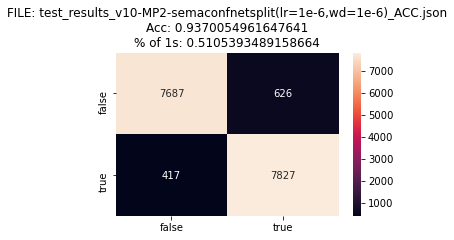

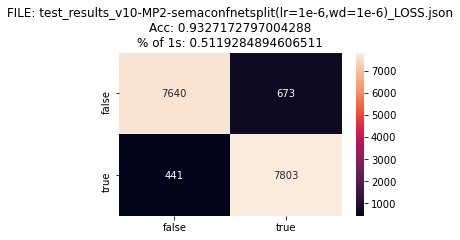

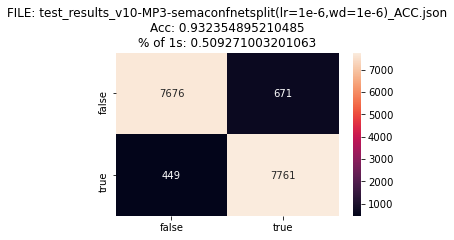

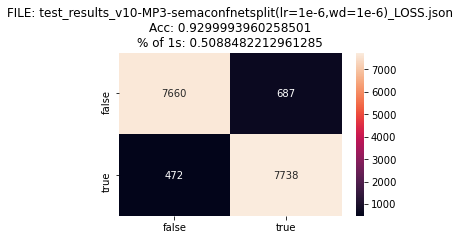

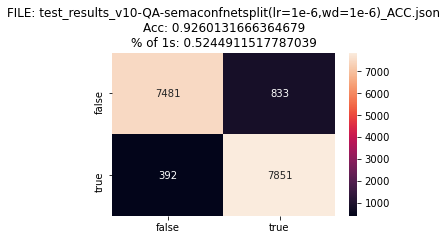

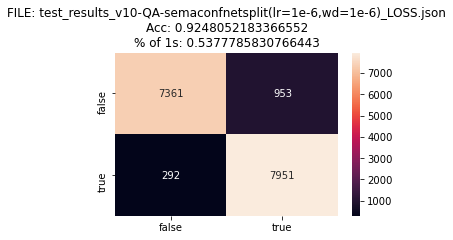

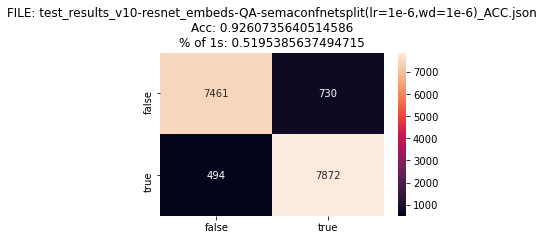

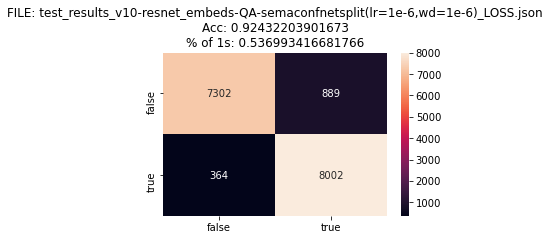

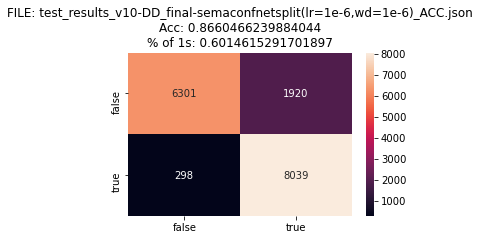

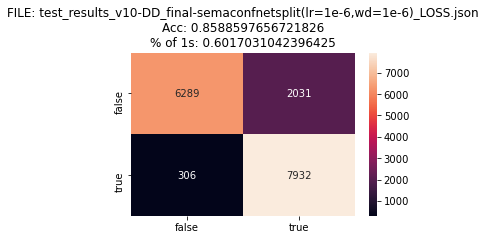

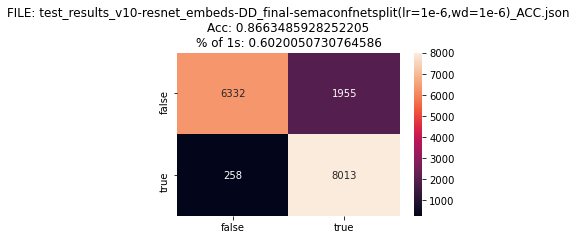

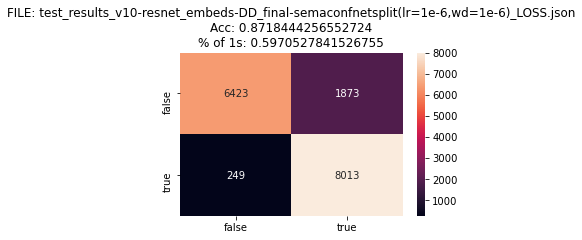

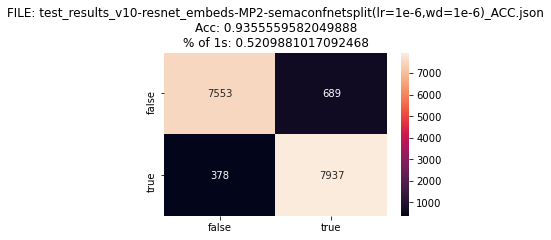

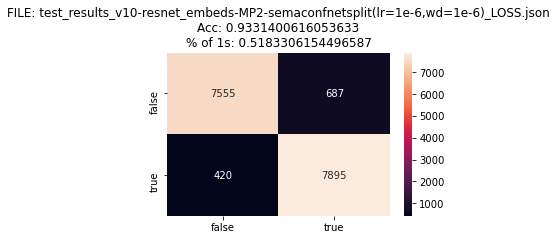

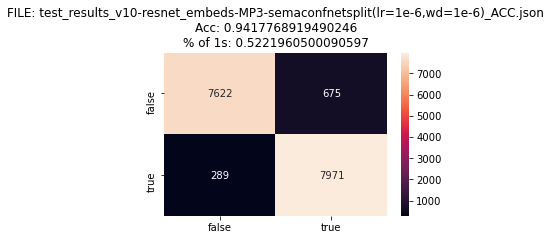

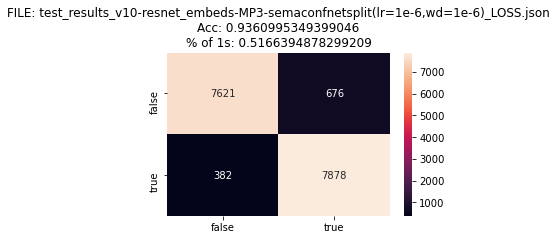

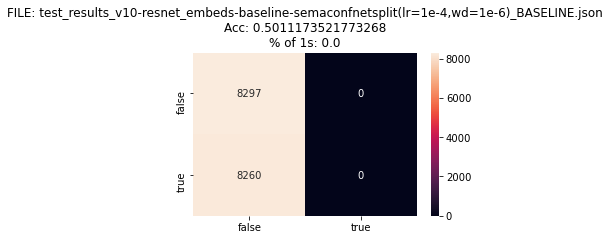

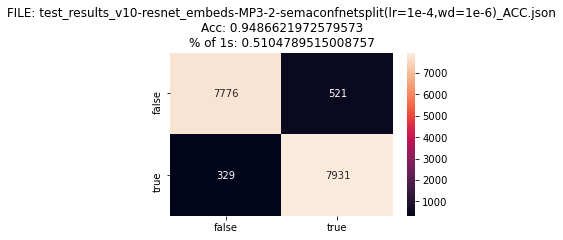

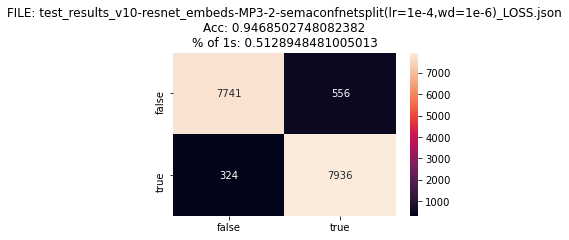

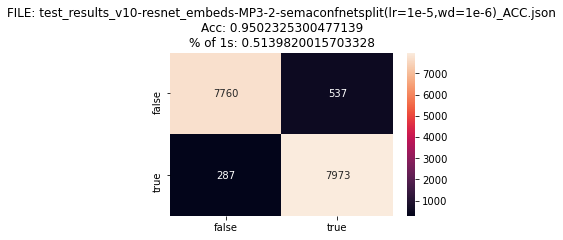

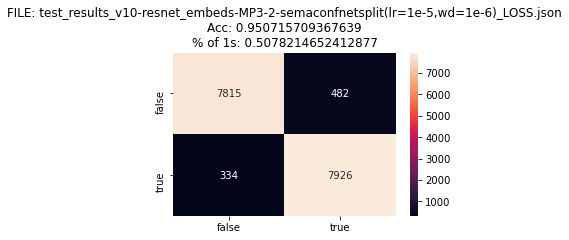

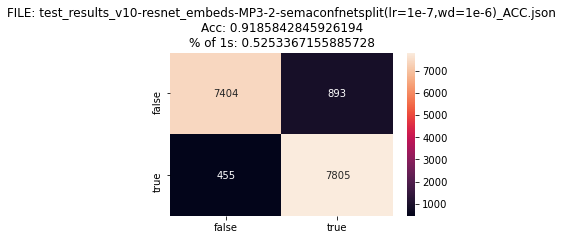

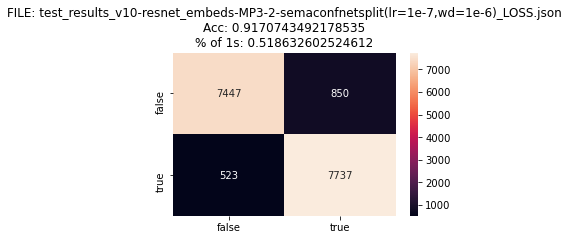

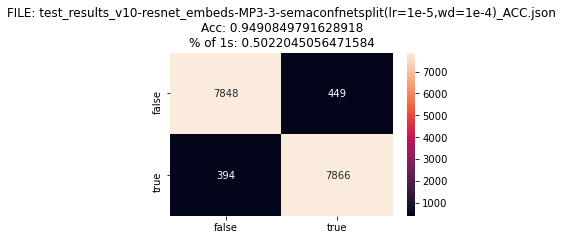

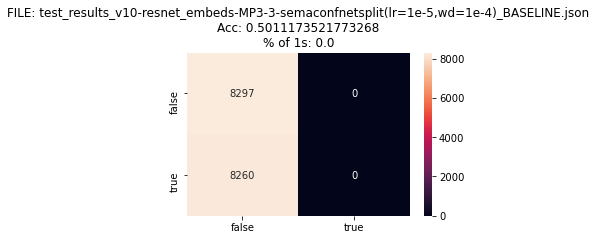

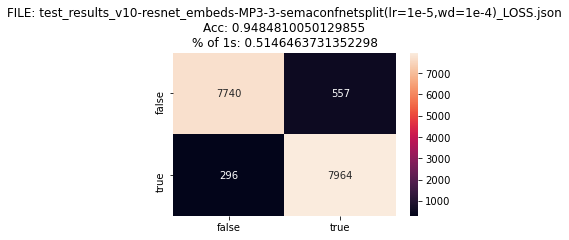

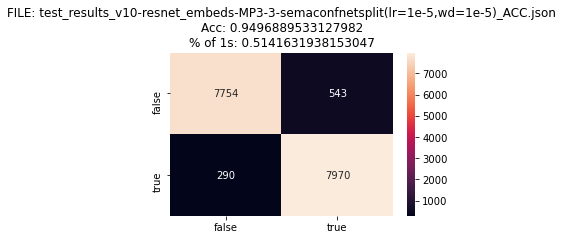

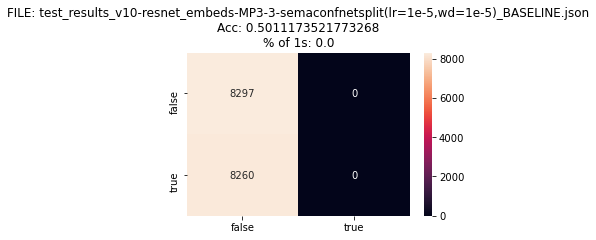

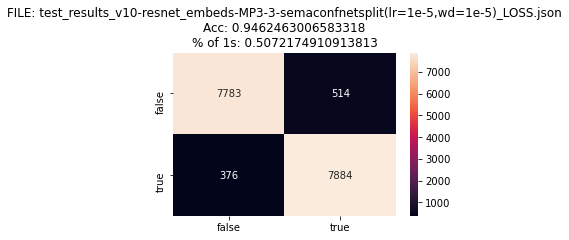

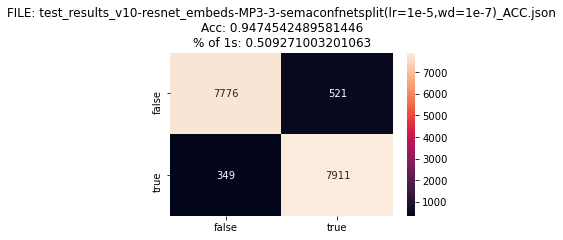

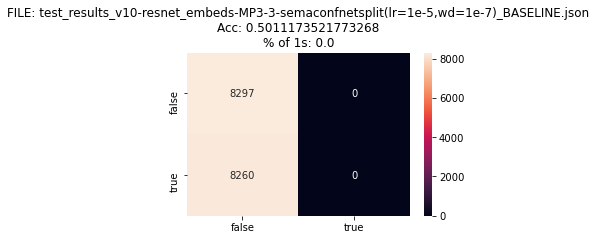

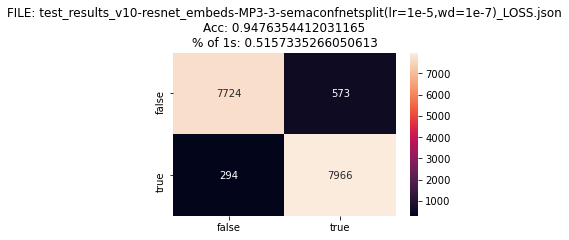

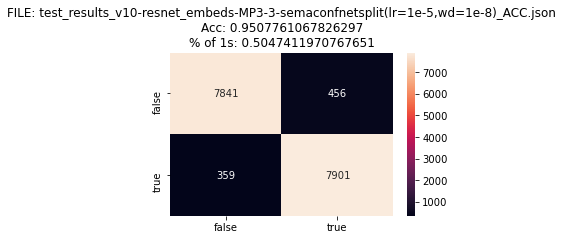

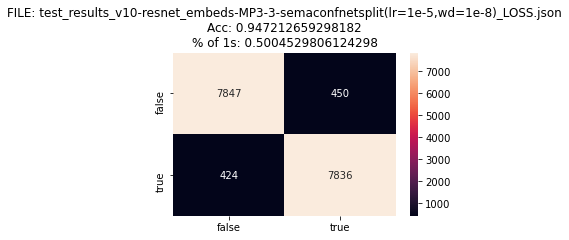

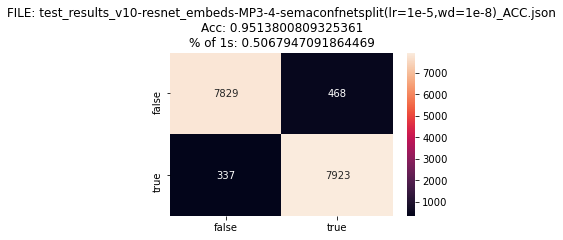

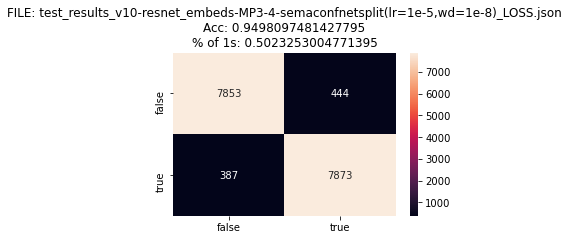

In [1165]:
# i-th row and j-th column shows when i-th class was true and j-th class was predicted

from sklearn.metrics import confusion_matrix


version = 'v9'
results_path = '/mnt/zeta_share_1/mkorchev/image_captioning/models/SemaConfNet/{}/results/'
plots_folder = '/mnt/zeta_share_1/mkorchev/image_captioning/models/{}/plots/'


for v in [
#         'v2-2',
#         'v2-3',
#         'v2-4',
#         'v2-5',
#         'v2-6',
#         'v2-7',
#         'v2-8',
#         'v2-9',
#         'v2-10',
#         'v2-11',
#         'v2-12',
#         'v2-13',
#         'v3',
#         'v3-2',
#         'v3-3',
#         'v3-4',
#         'v3-5',
#         'v3-6',
#         'v3-7',
#         'v3-8',
#         'v3-9',
#         'v3-10',
#         'v3-11'
#         'v4-5',
#         'v5',
#         'v6-2',
#         'v6-3',
#         'v6-4',
#         'v7',
#         'v7-2',
#         'v7-2_extra_epochs',
#     'extra_simple-3_MP',
#     'v10',
#     'v10-DD',
    'v10-MP2',
    'v10-MP3',
#     'v10-doublecheck',
#     'v10-DD_doublecheck',
#     'v10-resnet_embeds',
#     'v10-resnet_embeds-DD',
    'v10-QA',
    'v10-resnet_embeds-QA',
#     'v10-DD_shuffled',
    'v10-DD_final',
    'v10-resnet_embeds-DD_final',
    'v10-resnet_embeds-MP2',
    'v10-resnet_embeds-MP3',
    'v10-resnet_embeds-baseline',
    'v10-resnet_embeds-MP3-2',
    'v10-resnet_embeds-MP3-3',
    'v10-resnet_embeds-MP3-4'
    ]:
    print('VERSION ', v)
    filenames = sorted(os.listdir(results_path.format(v)))
    for f in filenames:
        with open(os.path.join(results_path.format(v), f), 'r') as r:
            result = json.load(r)
#             print('FILE: {}'.format(f))
            actuals = np.array(result['gt']).astype(float)
            predictions = np.array(result['pred']).astype(float)
            accuracy = result['acc']
            
            actuals[actuals <= 0.5] = 0.
            actuals[actuals > 0.5] = 1.

            predictions[predictions <= 0.5] = 0.
            predictions[predictions > 0.5] = 1. 
            
            cm = confusion_matrix(actuals, predictions)
            df_cm = pd.DataFrame(cm, index = [i for i in ["false", "true"]],
                  columns = [i for i in ["false", "true"]])
            
            plt.figure(figsize = (5,3))
            plt.title('FILE: {}\nAcc: {}\n% of 1s: {}'.format(f, accuracy, np.count_nonzero(predictions) / len(predictions)))
            sn.heatmap(df_cm, annot=True, fmt='d')

In [976]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/criss_cross_data/tmp/coco/dataset.json', 'r') as f:
    tmp = json.load(f)
tmp

{'images': [{'filepath': 'val2014',
   'sentids': [770337, 771687, 772707, 776154, 781998],
   'filename': 'COCO_val2014_000000391895.jpg',
   'imgid': 0,
   'split': 'test',
   'sentences': [{'tokens': ['a',
      'man',
      'with',
      'a',
      'red',
      'helmet',
      'on',
      'a',
      'small',
      'moped',
      'on',
      'a',
      'dirt',
      'road'],
     'raw': 'A man with a red helmet on a small moped on a dirt road. ',
     'imgid': 0,
     'sentid': 770337},
    {'tokens': ['man',
      'riding',
      'a',
      'motor',
      'bike',
      'on',
      'a',
      'dirt',
      'road',
      'on',
      'the',
      'countryside'],
     'raw': 'Man riding a motor bike on a dirt road on the countryside.',
     'imgid': 0,
     'sentid': 771687},
    {'tokens': ['a',
      'man',
      'riding',
      'on',
      'the',
      'back',
      'of',
      'a',
      'motorcycle'],
     'raw': 'A man riding on the back of a motorcycle.',
     'imgid': 0,
     '

In [978]:
tmp['images'][0]
    

{'filepath': 'val2014',
 'sentids': [770337, 771687, 772707, 776154, 781998],
 'filename': 'COCO_val2014_000000391895.jpg',
 'imgid': 0,
 'split': 'test',
 'sentences': [{'tokens': ['a',
    'man',
    'with',
    'a',
    'red',
    'helmet',
    'on',
    'a',
    'small',
    'moped',
    'on',
    'a',
    'dirt',
    'road'],
   'raw': 'A man with a red helmet on a small moped on a dirt road. ',
   'imgid': 0,
   'sentid': 770337},
  {'tokens': ['man',
    'riding',
    'a',
    'motor',
    'bike',
    'on',
    'a',
    'dirt',
    'road',
    'on',
    'the',
    'countryside'],
   'raw': 'Man riding a motor bike on a dirt road on the countryside.',
   'imgid': 0,
   'sentid': 771687},
  {'tokens': ['a',
    'man',
    'riding',
    'on',
    'the',
    'back',
    'of',
    'a',
    'motorcycle'],
   'raw': 'A man riding on the back of a motorcycle.',
   'imgid': 0,
   'sentid': 772707},
  {'tokens': ['a',
    'dirt',
    'path',
    'with',
    'a',
    'young',
    'person',

In [1325]:
criss_cross_validation = pd.read_csv('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/criss_cross_data/Crisscrossed-Captions-master/data/sits_val.csv')
criss_cross_validation

caption                          image  agg_score  \
0      COCO_val2014:sentid:648388  COCO_val2014_000000431431.jpg       1.80   
1      COCO_val2014:sentid:346617  COCO_val2014_000000302572.jpg       4.99   
2       COCO_val2014:sentid:33416  COCO_val2014_000000545309.jpg       2.93   
3      COCO_val2014:sentid:231384  COCO_val2014_000000498596.jpg       4.40   
4      COCO_val2014:sentid:767085  COCO_val2014_000000535770.jpg       3.51   
...                           ...                            ...        ...   
44717  COCO_val2014:sentid:194195  COCO_val2014_000000296759.jpg       5.00   
44718  COCO_val2014:sentid:681960  COCO_val2014_000000306619.jpg       5.00   
44719  COCO_val2014:sentid:442009  COCO_val2014_000000496718.jpg       5.00   
44720   COCO_val2014:sentid:61327  COCO_val2014_000000451949.jpg       4.92   
44721  COCO_val2014:sentid:498177  COCO_val2014_000000144959.jpg       5.00   

      sampling_method  
0        c2i_intrasim  
1        c2i_intrasim  
2        c2i_intrasim  
3        c2i_intrasim  
4        c2i_intrasim  
...               ...  
44717    c2i_original  
44718    c2i_original  
44719    c2i_original  
44720    c2i_original  
44721    c2i_original  

[44722 rows x 4 columns]

In [1326]:
criss_cross_test = pd.read_csv('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/criss_cross_data/Crisscrossed-Captions-master/data/sits_test.csv')
criss_cross_test

caption                          image  agg_score  \
0      COCO_val2014:sentid:732091  COCO_val2014_000000365325.jpg       2.20   
1      COCO_val2014:sentid:262300  COCO_val2014_000000369373.jpg       4.97   
2      COCO_val2014:sentid:635289  COCO_val2014_000000374677.jpg       2.72   
3      COCO_val2014:sentid:712230  COCO_val2014_000000292685.jpg       3.87   
4      COCO_val2014:sentid:620103  COCO_val2014_000000488697.jpg       4.54   
...                           ...                            ...        ...   
44828  COCO_val2014:sentid:826142  COCO_val2014_000000558483.jpg       4.95   
44829  COCO_val2014:sentid:328207  COCO_val2014_000000178578.jpg       4.98   
44830  COCO_val2014:sentid:144922  COCO_val2014_000000492506.jpg       4.92   
44831  COCO_val2014:sentid:146302  COCO_val2014_000000492506.jpg       4.91   
44832  COCO_val2014:sentid:650354  COCO_val2014_000000074478.jpg       4.62   

      sampling_method  
0        c2i_intrasim  
1        c2i_intrasim  
2        c2i_intrasim  
3        c2i_intrasim  
4        c2i_intrasim  
...               ...  
44828    c2i_original  
44829    c2i_original  
44830    c2i_original  
44831    c2i_original  
44832    c2i_original  

[44833 rows x 4 columns]

In [1327]:
criss_cross_validation['caption_id'] = criss_cross_validation['caption'].str.split(':').str[2]
criss_cross_test['caption_id'] = criss_cross_test['caption'].str.split(':').str[2]

caption             object
image               object
agg_score          float64
sampling_method     object
caption_id          object
dtype: object

caption                          image  agg_score  \
0      COCO_val2014:sentid:648388  COCO_val2014_000000431431.jpg       1.80   
1      COCO_val2014:sentid:346617  COCO_val2014_000000302572.jpg       4.99   
2       COCO_val2014:sentid:33416  COCO_val2014_000000545309.jpg       2.93   
3      COCO_val2014:sentid:231384  COCO_val2014_000000498596.jpg       4.40   
4      COCO_val2014:sentid:767085  COCO_val2014_000000535770.jpg       3.51   
...                           ...                            ...        ...   
44717  COCO_val2014:sentid:194195  COCO_val2014_000000296759.jpg       5.00   
44718  COCO_val2014:sentid:681960  COCO_val2014_000000306619.jpg       5.00   
44719  COCO_val2014:sentid:442009  COCO_val2014_000000496718.jpg       5.00   
44720   COCO_val2014:sentid:61327  COCO_val2014_000000451949.jpg       4.92   
44721  COCO_val2014:sentid:498177  COCO_val2014_000000144959.jpg       5.00   

      sampling_method caption_id  image_id  
0        c2i_intrasim     648388  431431.0  
1        c2i_intrasim     346617  302572.0  
2        c2i_intrasim      33416  545309.0  
3        c2i_intrasim     231384  498596.0  
4        c2i_intrasim     767085  535770.0  
...               ...        ...       ...  
44717    c2i_original     194195  296759.0  
44718    c2i_original     681960  306619.0  
44719    c2i_original     442009  496718.0  
44720    c2i_original      61327  451949.0  
44721    c2i_original     498177  144959.0  

[44722 rows x 6 columns]

In [1332]:
for img_id in name_to_id_map:
    criss_cross_validation.loc[criss_cross_validation['image'] == img_id, ['image_id']] = name_to_id_map[img_id]
    criss_cross_test.loc[criss_cross_test['image'] == img_id, ['image_id']] = name_to_id_map[img_id]

In [1333]:
criss_cross_validation['image_id'] = criss_cross_validation['image_id'].astype(int)
criss_cross_test['image_id'] = criss_cross_test['image_id'].astype(int)

criss_cross_validation['caption_id'] = criss_cross_validation['caption_id'].astype(int)
criss_cross_test['caption_id'] = criss_cross_test['caption_id'].astype(int)

In [1334]:
criss_cross_test.to_csv('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/criss_cross_data/sits_test_processed.csv', index=False)
criss_cross_validation.to_csv('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/criss_cross_data/sits_val_processed.csv', index=False)


In [1290]:
criss_cross_validation_true_only = criss_cross_validation.loc[criss_cross_validation['sampling_method'] == 'c2i_original']
criss_cross_test_true_only = criss_cross_test.loc[criss_cross_test['sampling_method'] == 'c2i_original']
criss_cross_validation_true_only['image_id'] = criss_cross_validation_true_only['image_id'].astype(int)
criss_cross_test_true_only['image_id'] = criss_cross_test_true_only['image_id'].astype(int)
criss_cross_test_true_only

caption                          image  agg_score  \
19833  COCO_val2014:sentid:522282  COCO_val2014_000000487375.jpg       4.98   
19834  COCO_val2014:sentid:207037  COCO_val2014_000000403863.jpg       4.97   
19835  COCO_val2014:sentid:624449  COCO_val2014_000000553879.jpg       4.97   
19836  COCO_val2014:sentid:319523  COCO_val2014_000000250311.jpg       4.98   
19837  COCO_val2014:sentid:646801  COCO_val2014_000000557998.jpg       4.95   
...                           ...                            ...        ...   
44828  COCO_val2014:sentid:826142  COCO_val2014_000000558483.jpg       4.95   
44829  COCO_val2014:sentid:328207  COCO_val2014_000000178578.jpg       4.98   
44830  COCO_val2014:sentid:144922  COCO_val2014_000000492506.jpg       4.92   
44831  COCO_val2014:sentid:146302  COCO_val2014_000000492506.jpg       4.91   
44832  COCO_val2014:sentid:650354  COCO_val2014_000000074478.jpg       4.62   

      sampling_method caption_id  image_id  
19833    c2i_original     522282    487375  
19834    c2i_original     207037    403863  
19835    c2i_original     624449    553879  
19836    c2i_original     319523    250311  
19837    c2i_original     646801    557998  
...               ...        ...       ...  
44828    c2i_original     826142    558483  
44829    c2i_original     328207    178578  
44830    c2i_original     144922    492506  
44831    c2i_original     146302    492506  
44832    c2i_original     650354     74478  

[25000 rows x 6 columns]

In [1291]:
img_means_val = json.loads(criss_cross_validation_true_only.groupby('image_id')['agg_score'].mean().to_json())
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/criss_cross_data/img_id_to_cc_score_val.json', 'w') as f: 
    json.dump(img_means_val, f)
    
img_means_test = json.loads(criss_cross_test_true_only.groupby('image_id')['agg_score'].mean().to_json())
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/criss_cross_data/img_id_to_cc_score_test.json', 'w') as f: 
    json.dump(img_means_test, f)

In [1330]:
img_means_val

{'139': 4.858,
 '285': 4.988,
 '474': 4.942,
 '661': 4.88,
 '939': 4.946,
 '985': 4.876,
 '1153': 4.914,
 '1340': 4.804,
 '1347': 4.944,
 '1369': 4.958,
 '1464': 4.586,
 '1503': 4.9,
 '1532': 4.842,
 '1554': 4.918,
 '1647': 4.73,
 '1668': 4.934,
 '1799': 4.878,
 '2006': 4.538,
 '2212': 4.922,
 '2255': 4.644,
 '2495': 4.976,
 '2532': 4.856,
 '2587': 4.812,
 '2985': 4.798,
 '3067': 4.888,
 '3310': 4.964,
 '3690': 4.948,
 '3761': 4.958,
 '3865': 4.75,
 '4011': 4.864,
 '4092': 4.816,
 '4108': 4.968,
 '4157': 4.902,
 '4283': 4.794,
 '4375': 4.708,
 '4438': 4.914,
 '4576': 4.866,
 '4678': 4.832,
 '4764': 4.898,
 '4840': 4.878,
 '5032': 4.832,
 '5124': 4.97,
 '5225': 4.832,
 '5278': 4.756,
 '5282': 4.922,
 '5477': 4.954,
 '5635': 4.596,
 '5652': 4.718,
 '5724': 4.922,
 '5728': 4.972,
 '5754': 4.992,
 '5820': 4.938,
 '6012': 4.942,
 '6019': 4.966,
 '6306': 4.974,
 '6527': 4.848,
 '6658': 4.8,
 '6688': 4.874,
 '6701': 4.84,
 '6810': 4.714,
 '6954': 4.89,
 '7107': 4.898,
 '7207': 4.766,
 '7320':

In [1343]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v6/total_scores_val_1v1_v6.json', 'r') as f: 
    tmp = json.load(f)

In [1292]:
cc_scores_list = []
for img in tmp:
    if str(img['id']) in img_means_val:
        cc_scores_list.append({
            'id': img['id'],
            'file_name': img['file_name'],
            'avg_cc': img_means_val[str(img['id'])]
        })
    elif str(img['id']) in img_means_test:
        cc_scores_list.append({
            'id': img['id'],
            'file_name': img['file_name'],
            'avg_cc': img_means_test[str(img['id'])]
        })

with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v6/criss_cross_averages.json', 'w') as f:
    json.dump(cc_scores_list, f)

In [1344]:
tmp[0]

{'id': 391895,
 'file_name': 'COCO_val2014_000000391895.jpg',
 'data': {'scores': {'771687': {'caption': 'man riding a motor bike on a dirt road on the countryside.',
    'metrics': [{'metric_id': 'b_score',
      'results': {'scores': [0.7241379310344828,
        0.6379310344827587,
        0.2047005915353754,
        0.7131416736519752],
       'average': 0.569977807676148,
       'variance': 0.04557658045499625,
       'std_deviation': 0.21348672196414523}},
     {'metric_id': 'rouge2',
      'results': {'scores': [0.24999999999999994,
        0.2105263157894737,
        0.2051282051282051,
        0.07142857142857142],
       'average': 0.18427077308656253,
       'variance': 0.004544519934914251,
       'std_deviation': 0.06741305463272118}},
     {'metric_id': 'rouge3',
      'results': {'scores': [0.1818181818181818,
        0.0,
        0.05405405405405406,
        0.0],
       'average': 0.05896805896805896,
       'variance': 0.005517691021376524,
       'std_deviation': 0.07

In [1335]:
criss_cross_confidence_data = pd.read_csv('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/criss_cross_data/sits_val_final.csv')

In [1338]:
criss_cross_confidence_data

caption                          image  agg_score  \
0      COCO_val2014:sentid:648388  COCO_val2014_000000431431.jpg       1.80   
1      COCO_val2014:sentid:346617  COCO_val2014_000000302572.jpg       4.99   
2       COCO_val2014:sentid:33416  COCO_val2014_000000545309.jpg       2.93   
3      COCO_val2014:sentid:231384  COCO_val2014_000000498596.jpg       4.40   
4      COCO_val2014:sentid:767085  COCO_val2014_000000535770.jpg       3.51   
...                           ...                            ...        ...   
44717  COCO_val2014:sentid:194195  COCO_val2014_000000296759.jpg       5.00   
44718  COCO_val2014:sentid:681960  COCO_val2014_000000306619.jpg       5.00   
44719  COCO_val2014:sentid:442009  COCO_val2014_000000496718.jpg       5.00   
44720   COCO_val2014:sentid:61327  COCO_val2014_000000451949.jpg       4.92   
44721  COCO_val2014:sentid:498177  COCO_val2014_000000144959.jpg       5.00   

      sampling_method  caption_id  image_id  semaconfnet_result  
0        c2i_intrasim      648388    431431            0.819831  
1        c2i_intrasim      346617    302572            0.629505  
2        c2i_intrasim       33416    545309            0.778053  
3        c2i_intrasim      231384    498596            0.648779  
4        c2i_intrasim      767085    535770            0.696493  
...               ...         ...       ...                 ...  
44717    c2i_original      194195    296759            0.754651  
44718    c2i_original      681960    306619            0.735849  
44719    c2i_original      442009    496718            0.805485  
44720    c2i_original       61327    451949            0.758113  
44721    c2i_original      498177    144959            0.822532  

[44722 rows x 7 columns]

In [1349]:
for img in tmp:
    for cap_id in img['data']['scores']:
        for metric in img['data']['scores'][cap_id]['metrics']:
            criss_cross_confidence_data.loc[criss_cross_confidence_data['caption_id'] == int(cap_id), [metric['metric_id']]] = metric['results']['average']

In [1350]:
criss_cross_confidence_data

caption                          image  agg_score  \
0      COCO_val2014:sentid:648388  COCO_val2014_000000431431.jpg       1.80   
1      COCO_val2014:sentid:346617  COCO_val2014_000000302572.jpg       4.99   
2       COCO_val2014:sentid:33416  COCO_val2014_000000545309.jpg       2.93   
3      COCO_val2014:sentid:231384  COCO_val2014_000000498596.jpg       4.40   
4      COCO_val2014:sentid:767085  COCO_val2014_000000535770.jpg       3.51   
...                           ...                            ...        ...   
44717  COCO_val2014:sentid:194195  COCO_val2014_000000296759.jpg       5.00   
44718  COCO_val2014:sentid:681960  COCO_val2014_000000306619.jpg       5.00   
44719  COCO_val2014:sentid:442009  COCO_val2014_000000496718.jpg       5.00   
44720   COCO_val2014:sentid:61327  COCO_val2014_000000451949.jpg       4.92   
44721  COCO_val2014:sentid:498177  COCO_val2014_000000144959.jpg       5.00   

      sampling_method  caption_id  image_id  semaconfnet_result   b_score  \
0        c2i_intrasim      648388    431431            0.819831  0.720339   
1        c2i_intrasim      346617    302572            0.629505  0.754237   
2        c2i_intrasim       33416    545309            0.778053  0.750506   
3        c2i_intrasim      231384    498596            0.648779  0.739598   
4        c2i_intrasim      767085    535770            0.696493  0.722656   
...               ...         ...       ...                 ...       ...   
44717    c2i_original      194195    296759            0.754651  0.602217   
44718    c2i_original      681960    306619            0.735849  0.666897   
44719    c2i_original      442009    496718            0.805485  0.625000   
44720    c2i_original       61327    451949            0.758113  0.704428   
44721    c2i_original      498177    144959            0.822532  0.693240   

         rouge2    rouge3    rougeL    meteor      bert     cider  
0      0.025000  0.000000  0.224308  0.125672  0.315391  0.795090  
1      0.145455  0.080556  0.289773  0.227480  0.448503  1.223963  
2      0.202381  0.076923  0.476103  0.368153  0.663323  1.855688  
3      0.160417  0.074176  0.421569  0.320953  0.543540  1.087859  
4      0.105455  0.021739  0.486111  0.418760  0.628979  1.501362  
...         ...       ...       ...       ...       ...       ...  
44717  0.043478  0.000000  0.189312  0.202899  0.327232  0.901778  
44718  0.107143  0.031250  0.322921  0.270230  0.653869  1.531045  
44719  0.382788  0.345614  0.577101  0.343983  0.656032  2.775554  
44720  0.060662  0.000000  0.321637  0.243134  0.456945  1.193502  
44721  0.055556  0.000000  0.286111  0.151765  0.339093  0.909810  

[44722 rows x 14 columns]

In [1353]:
criss_cross_confidence_data_true = criss_cross_confidence_data.loc[criss_cross_confidence_data['sampling_method'] == 'c2i_original']

In [1355]:
print('corr bleu: ', criss_cross_confidence_data_true['agg_score'].corr(criss_cross_confidence_data_true['b_score']))
print('corr rouge2: ', criss_cross_confidence_data_true['agg_score'].corr(criss_cross_confidence_data_true['rouge2']))
print('corr rouge3: ', criss_cross_confidence_data_true['agg_score'].corr(criss_cross_confidence_data_true['rouge3']))
print('corr rougeL: ', criss_cross_confidence_data_true['agg_score'].corr(criss_cross_confidence_data_true['rougeL']))
print('corr meteor: ', criss_cross_confidence_data_true['agg_score'].corr(criss_cross_confidence_data_true['meteor']))
print('corr bert: ', criss_cross_confidence_data_true['agg_score'].corr(criss_cross_confidence_data_true['bert']))
print('corr cider: ', criss_cross_confidence_data_true['agg_score'].corr(criss_cross_confidence_data_true['cider']))

corr bleu:  0.0647393082976318
corr rouge2:  0.10947492900538343
corr rouge3:  0.07591269520854389
corr rougeL:  0.1366040744846773
corr meteor:  0.129994034186826
corr bert:  0.14730065137867102
corr cider:  0.13642809475159554


In [1446]:
print('corr bleu: ', criss_cross_confidence_data_true['semaconfnet_result'].corr(criss_cross_confidence_data_true['b_score']))
print('corr rouge2: ', criss_cross_confidence_data_true['semaconfnet_result'].corr(criss_cross_confidence_data_true['rouge2']))
print('corr rouge3: ', criss_cross_confidence_data_true['semaconfnet_result'].corr(criss_cross_confidence_data_true['rouge3']))
print('corr rougeL: ', criss_cross_confidence_data_true['semaconfnet_result'].corr(criss_cross_confidence_data_true['rougeL']))
print('corr meteor: ', criss_cross_confidence_data_true['semaconfnet_result'].corr(criss_cross_confidence_data_true['meteor']))
print('corr bert: ', criss_cross_confidence_data_true['semaconfnet_result'].corr(criss_cross_confidence_data_true['bert']))
print('corr cider: ', criss_cross_confidence_data_true['semaconfnet_result'].corr(criss_cross_confidence_data_true['cider']))

corr bleu:  0.031387578930333775
corr rouge2:  0.048240303447022875
corr rouge3:  0.03932947710383554
corr rougeL:  0.0833823436994786
corr meteor:  0.07190037033601716
corr bert:  0.09823337924028688
corr cider:  0.0551213627683824


In [1437]:
criss_cross_confidence_data_true = criss_cross_confidence_data_true.drop(criss_cross_confidence_data_true[criss_cross_confidence_data_true['agg_score'] == 4.8].sample(frac=0.5).index)

ValueError: supplied range of [-inf, 1.6094379124341003] is not finite

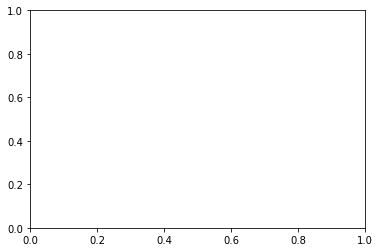

In [1441]:
criss_cross_confidence_data_true['agg_score_log'].hist(bins=100)

In [1443]:
criss_cross_confidence_data_true['agg_score_log'] = np.log(criss_cross_confidence_data_true['agg_score'])
criss_cross_confidence_data_true['agg_score_norm'] = criss_cross_confidence_data_true['agg_score'] / criss_cross_confidence_data_true['agg_score'].abs().max()
# criss_cross_confidence_data_true['agg_score_boxcox'] = scipy.stats.boxcox(criss_cross_confidence_data_true['agg_score'])

criss_cross_confidence_data_true.replace([np.inf, -np.inf], 0, inplace=True)

<AxesSubplot:>

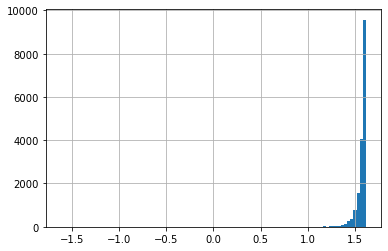

In [1445]:
criss_cross_confidence_data_true['agg_score_log'].hist(bins=100)

<AxesSubplot:>

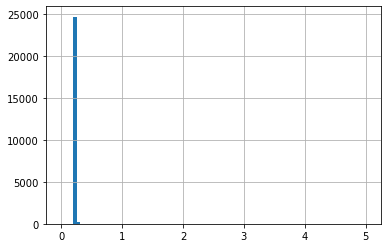

In [1380]:
criss_cross_confidence_data_true['agg_score_recip'].hist(bins=100)

In [1356]:
criss_cross_confidence_data_true.to_csv('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/criss_cross_data/sits_val_final_with_scores.csv', index=False)


VERSION v1-cc_oracle


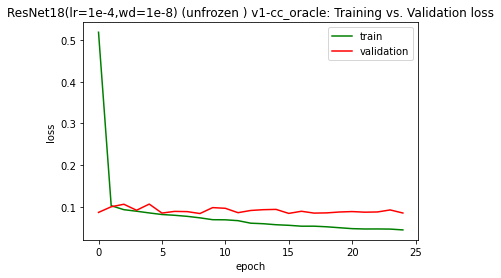

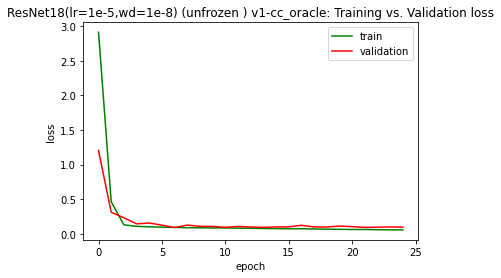

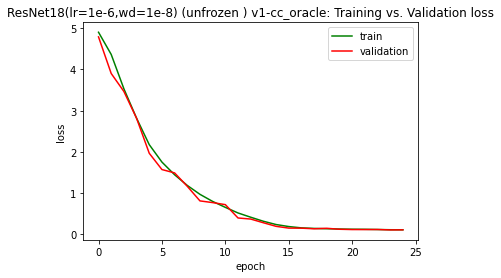

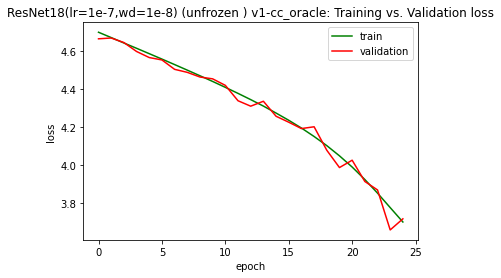

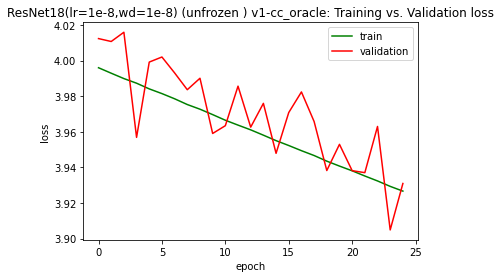

VERSION v2-cc_oracle


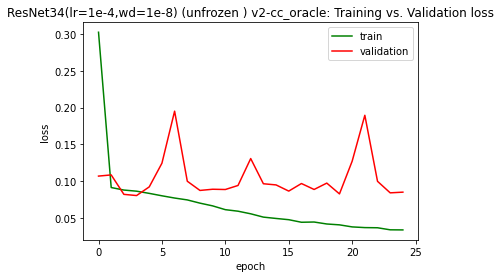

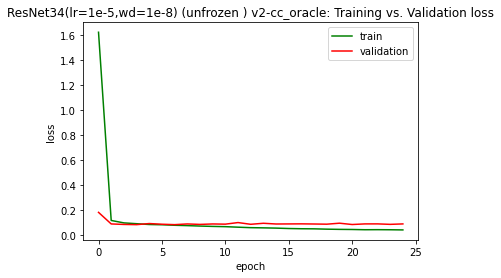

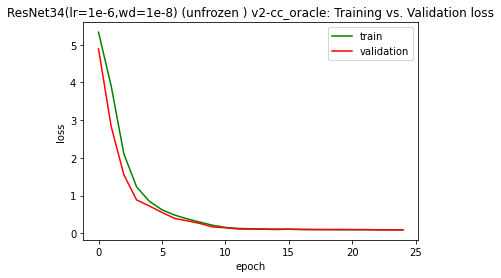

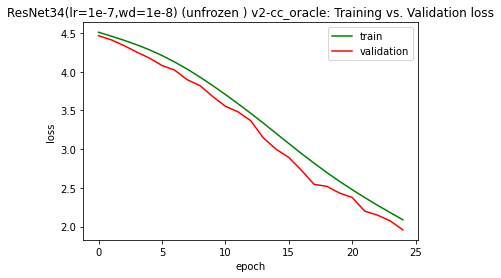

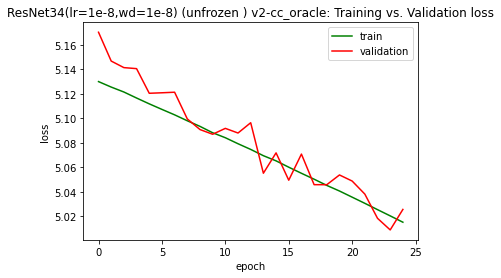

In [1313]:
versions = [
    'v1-cc_oracle',
    'v2-cc_oracle',
#     'v3-cc_oracle'
]
log_folder = '/mnt/zeta_share_1/mkorchev/image_captioning/models/CrissCrossOracle/{}/logs/'
logfiles = []
for v in versions:
    print('VERSION {}'.format(v))
    folder = log_folder.format(v)
    logs = sorted(os.listdir(folder))
    for log in logs: 
        
        log_id =  log.replace('-LOG.log', '')
        training_loss = []
        validation_loss = []
        logfile = open(os.path.join(folder, log), 'r')
        line = '****'
        while line:
            line = logfile.readline()
            if line != '':
                s = line.strip('\n').split(',')
                train = s[0]
                val = s[1]
                training_loss.append(float(train))
                validation_loss.append(float(val))
        logfile.close()
        plt.plot(range(len(training_loss)), np.array(training_loss), c='green', label='train')
        plt.plot(range(len(validation_loss)), np.array(validation_loss), c='red', label='validation')
        plt.legend(loc="upper right")
        plt.title('{}: Training vs. Validation loss'.format(log_id))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

VERSION  v1-cc_oracle
FILE: test_results_v1-cc_oracle(lr=1e-4,wd=1e-8)_unfrozen .json


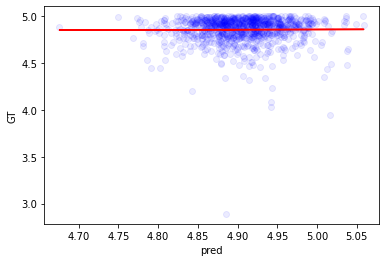

pearson score: 0.00606952840807419
slope: 0.01794167402780467
FILE: test_results_v1-cc_oracle(lr=1e-5,wd=1e-8)_unfrozen .json


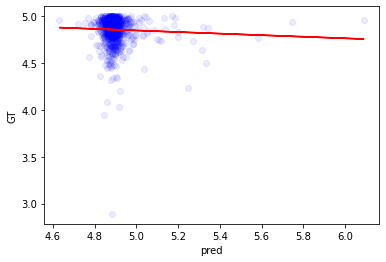

pearson score: -0.04424281303253698
slope: -0.0835958774507498
FILE: test_results_v1-cc_oracle(lr=1e-6,wd=1e-8)_unfrozen .json


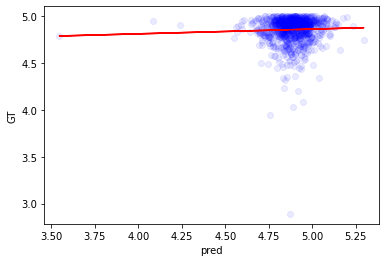

pearson score: 0.03832015113082417
slope: 0.050508289754368954
FILE: test_results_v1-cc_oracle(lr=1e-7,wd=1e-8)_unfrozen .json


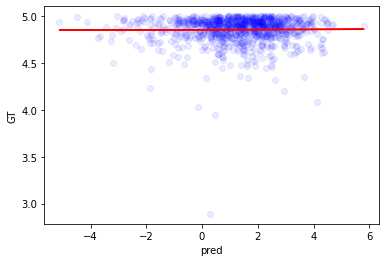

pearson score: 0.010112351576256826
slope: 0.0009460928560981201
FILE: test_results_v1-cc_oracle(lr=1e-8,wd=1e-8)_unfrozen .json


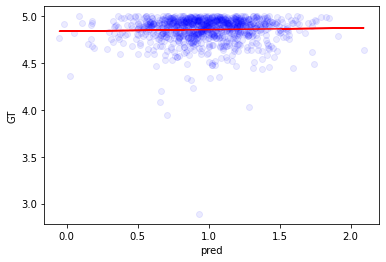

pearson score: 0.034448314174094816
slope: 0.016646891131225326
VERSION  v2-cc_oracle
FILE: test_results_v2-cc_oracle(lr=1e-4,wd=1e-8)_unfrozen .json


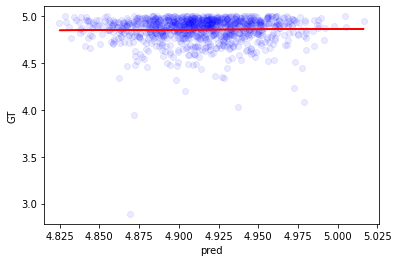

pearson score: 0.01986549165496991
slope: 0.08818873005712992
FILE: test_results_v2-cc_oracle(lr=1e-5,wd=1e-8)_unfrozen .json


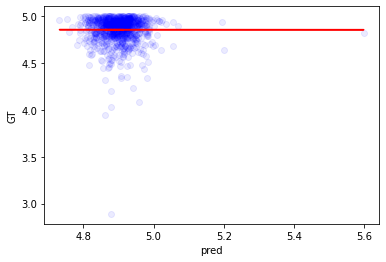

pearson score: -0.00026172649047748187
slope: -0.00072395153581976
FILE: test_results_v2-cc_oracle(lr=1e-6,wd=1e-8)_unfrozen .json


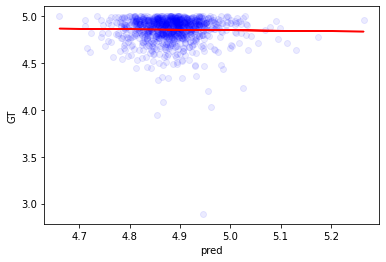

pearson score: -0.02175894647214271
slope: -0.053310689794369766
FILE: test_results_v2-cc_oracle(lr=1e-7,wd=1e-8)_unfrozen .json


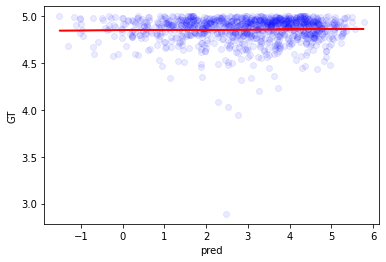

pearson score: 0.022618830309326737
slope: 0.0022701085652847733
FILE: test_results_v2-cc_oracle(lr=1e-8,wd=1e-8)_unfrozen .json


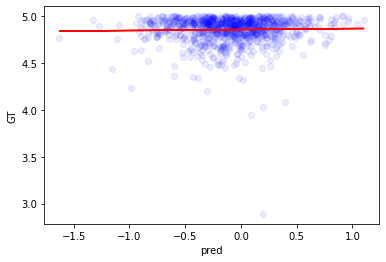

pearson score: 0.026888040120911907
slope: 0.010425627599591767


<Figure size 432x288 with 0 Axes>

In [1314]:
results_path = '/mnt/zeta_share_1/mkorchev/image_captioning/models/CrissCrossOracle/{}/results/'
plots_folder = '/mnt/zeta_share_1/mkorchev/image_captioning/models/CrissCrossOracle/{}/plots/'

for v in [
    'v1-cc_oracle', 
    'v2-cc_oracle'

    ]:
    print('VERSION ', v)
    filenames = sorted(os.listdir(results_path.format(v)))
    for f in filenames:
        with open(os.path.join(results_path.format(v), f), 'r') as r:
            result = json.load(r)
            print('FILE: {}'.format(f))
            actuals = np.array(result['gt']).astype(float)
            predictions = np.array(result['pred']).astype(float)
            pearson_score = scipy.stats.pearsonr(actuals, predictions)[0]
            plt.scatter(predictions, actuals, c='blue', alpha=0.08)
            m, b = np.polyfit(predictions, actuals, 1)
            plt.plot(predictions, m*predictions + b, c='red')
            plt.xlabel('pred')
            plt.ylabel('GT')
            plt.show()
            plt.clf()
            print('pearson score: {}'.format(result['pearson_score']))
            print('slope: {}'.format(m))

In [1176]:
# criss_cross_confidence_data['semaconfnet_result'].corr(criss_cross_confidence_data['agg_score'])
intrasim = criss_cross_confidence_data.loc[criss_cross_confidence_data['sampling_method'] == 'c2i_intrasim']
orig = criss_cross_confidence_data.loc[criss_cross_confidence_data['sampling_method'] == 'c2i_original']
criss_cross_confidence_data['agg_score'].corr(criss_cross_confidence_data['semaconfnet_result'])

0.05826838603284542

In [ ]:
name_to_id_map

In [1069]:
id_to_img_embed_map_val = {}
for img in total_embed_list:
    id_to_img_embed_map_val[img[0]] = img[1]

In [ ]:
id_to_img_embed_map_val

In [1061]:
cap_embeds = np.load('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/coco_val2014_captions_embed/coco2014val_caption_embeddings.npy', allow_pickle=True)

In [ ]:
cap_embeds

In [ ]:
id_to_cap_embed_map_val = {}
for cap in cap_embeds:
    id_to_cap_embed_map_val[cap[1]] = cap[2]
id_to_cap_embed_map_val

In [997]:
corpus = []
for image_id in tmp:
    for cap in tmp[image_id]:
        corpus.append({
            'image_id': str(image_id),
            'caption': cap['caption']
        })
    

In [1004]:
f = open(os.path.join('./codebase/coco_caption/data/coco_val2014_stem_df.p'), 'rb')
docFreq = pickle.load(f)

In [ ]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v6/total_scores_val_v6.json', 'r') as f: 
    tmp = json.load(f)

In [1028]:
b_scores_old = [img['data']['scores'][key]['metrics'][0]['results']['average'] for img in tmp_old for key in img['data']['scores']]

In [1029]:
b_scores = [img['data']['scores'][key]['metrics'][0]['results']['average'] for img in tmp for key in img['data']['scores']]

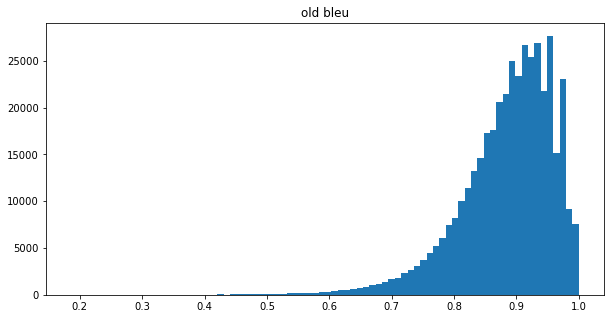

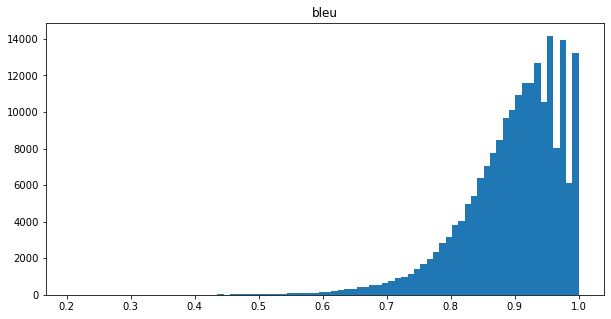

In [1030]:
plt.figure(figsize=(10,5))
plt.title('old bleu')
plt.hist(b_scores_old, bins=80, label='old')
plt.show()

plt.figure(figsize=(10,5))
plt.title('bleu')
plt.hist(b_scores, bins=80, label='old')
plt.show()

In [1323]:
a1 = np.array([1.0, 2.0, 3.0])
a2 = np.array([2.0, 3.0, 1.0])

In [1471]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v4/total_scores_v4_cider_1v1_stem(df_control).json', 'r') as f:
    meta4_1v1 = json.load(f)

In [1472]:
with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v4/total_scores_v4_cider(df_control).json', 'r') as f:
    meta4 = json.load(f)

In [1451]:

with open('/mnt/zeta_share_1/mkorchev/image_captioning/datasets/meta/v5/total_scores_v5.json', 'r') as f:
    meta5 = json.load(f)

In [1473]:
meta4_1v1[0]

{'id': 57870,
 'file_name': 'COCO_train2014_000000057870.jpg',
 'data': {'scores': {'789366': {'caption': 'a long restaurant table with rattan rounded back chairs.',
    'metrics': [{'metric_id': 'b_score',
      'results': {'scores': [0.7678571428571429,
        0.6654132876581892,
        0.6538574871966709,
        0.7857142857142857],
       'average': 0.7182105508565721,
       'variance': 0.003487601530166563,
       'std_deviation': 0.05905591867176873}},
     {'metric_id': 'rouge2',
      'results': {'scores': [0.0, 0.1904761904761905, 0.2105263157894737, 0.0],
       'average': 0.10025062656641605,
       'variance': 0.010100439067593798,
       'std_deviation': 0.1005009406303931}},
     {'metric_id': 'rouge3',
      'results': {'scores': [0.0, 0.0, 0.0, 0.0],
       'average': 0.0,
       'variance': 0.0,
       'std_deviation': 0.0}},
     {'metric_id': 'rougeL',
      'results': {'scores': [0.35294117647058826,
        0.43478260869565216,
        0.380952380952381,
      

In [1474]:
meta4[0]

{'id': 57870,
 'file_name': 'COCO_train2014_000000057870.jpg',
 'data': {'scores': {'789366': {'caption': 'a long restaurant table with rattan rounded back chairs.',
    'metrics': [{'metric_id': 'b_score',
      'results': {'scores': [0.7678571428571429,
        0.6654132876581892,
        0.6538574871966709,
        0.7857142857142857],
       'average': 0.7182105508565721,
       'variance': 0.003487601530166563,
       'std_deviation': 0.05905591867176873}},
     {'metric_id': 'rouge2',
      'results': {'scores': [0.0, 0.1904761904761905, 0.2105263157894737, 0.0],
       'average': 0.10025062656641605,
       'variance': 0.010100439067593798,
       'std_deviation': 0.1005009406303931}},
     {'metric_id': 'rouge3',
      'results': {'scores': [0.0, 0.0, 0.0, 0.0],
       'average': 0.0,
       'variance': 0.0,
       'std_deviation': 0.0}},
     {'metric_id': 'rougeL',
      'results': {'scores': [0.35294117647058826,
        0.43478260869565216,
        0.380952380952381,
      

In [1453]:
meta5[0]

{'id': 57870,
 'file_name': 'COCO_train2014_000000057870.jpg',
 'data': {'scores': {'789366': {'caption': 'a long restaurant table with rattan rounded back chairs.',
    'metrics': [{'metric_id': 'b_score',
      'results': {'scores': [0.9285714285714286,
        0.9285714285714286,
        0.9285714285714286,
        0.9285714285714286],
       'average': 0.9285714285714286,
       'variance': 0.0,
       'std_deviation': 0.0}},
     {'metric_id': 'rouge2',
      'results': {'scores': [0.2055137844611529,
        0.2055137844611529,
        0.2055137844611529,
        0.2055137844611529],
       'average': 0.2055137844611529,
       'variance': 0.0,
       'std_deviation': 0.0}},
     {'metric_id': 'rouge3',
      'results': {'scores': [0.0, 0.0, 0.0, 0.0],
       'average': 0.0,
       'variance': 0.0,
       'std_deviation': 0.0}},
     {'metric_id': 'rougeL',
      'results': {'scores': [0.22641509433962262,
        0.22641509433962262,
        0.22641509433962262,
        0.226415

In [ ]:
2+2